In [1]:
#importing necessary libraries
import os
import json
import pathlib
import warnings
import numpy as np
import pandas as pd

# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import binned_statistic_2d

#used for plots
from scipy import stats
import matplotlib.pyplot as plt
from mplsoccer import PyPizza, FontManager, Pitch

from tqdm import tqdm

tqdm.pandas()

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Project 2 - Scouting

### Instructions

*Think about a particular player position in your team (either your own team or Premier League team for which you have data) which needs strengthening:*
1. Implement one or two bespoke metrics (KPI) which measures this aspect of play. Look at this with respect to players in your own team or players in other teams who you know do this well

2. Decide on 3 or 4 other more general metrics to use

3. Rank players in the league based on the bespoke metrics, then create player radars for teh players near the top of the list.

### Position to scout: *CAM*

Possible metrics to use:
1. Passes into final third ending in good shots (DONE)
2. Succesful passes/crosses in final third (DONE)
3. Ground attacking and air duels won in opponents half (DONE)
4. xG/shot, Goals (DONE)
5. Progressive passes (forward) from middle of the pitch (maybe include xT)? (DONE)
6. Runs/dribbles into final third
7. Successful Dribbles

**Important**
- Adjust by 1-possesion for defensive metrics
- Use per 90 or adjusted by possession

#### Player Data

In [2]:
#path to data
path = os.path.join(str(pathlib.Path().resolve()), 'data', 'players.json')
#open data
with open(path) as f:
    data = json.load(f)
#save it in a dataframe
df_players = pd.DataFrame(data)
df_players = df_players.rename(columns={'wyId':'playerId'})

# get minutes played for the whole season per player
path = os.path.join(str(pathlib.Path().resolve()),'data','minutes_played_per_game_England.json') 
with open(path) as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

df_players = minutes.merge(df_players[['firstName','lastName','shortName','role','currentTeamId','playerId','foot']],how='inner',on=['playerId'])
df_players['role'] = df_players[['role']].apply(lambda x: x.role["name"], axis = 1)
df_players = df_players.loc[df_players['role']=='Midfielder']
df_players = df_players.loc[df_players["minutesPlayed"] > 400]
df_players = df_players.rename(columns={'currentTeamId':'teamId'})
df_players['teamId'] = df_players['teamId'].astype(str)
df_players['minutesPlayed'] = df_players['minutesPlayed'].astype(int)
print(f'Total number of players: {len(df_players)}')
df_players.sample(5)

Total number of players: 149


playerId  minutesPlayed firstName           lastName     shortName        role teamId   foot
330     41174           2126    Manuel            Lanzini    M. Lanzini  Midfielder   1633  right
302     25798           1619   Etienne             Capoue     E. Capoue  Midfielder   1644  right
203      8959           1338    Junior          Stanislas  J. Stanislas  Midfielder   1659  right
224      9414           2194      Matt           Phillips   M. Phillips  Midfielder   1627  right
469    339789           1419     Mikel  Merino Zaz\u00f3n  Mikel Merino  Midfielder    687   left

In [3]:
#Here we will try to get the team names with their respective IDs
path = os.path.join(str(pathlib.Path().resolve()),'data','teams.json') 
with open(path) as f:
    df_teams = json.load(f)
df_teams = pd.DataFrame(df_teams)
df_teams = df_teams.rename(columns={'wyId':'teamId','name':'teamName'})
df_teams = df_teams.loc[df_teams.apply(lambda x: (('England' in x.area['name'] or 'Wales' in x.area['name']) and 'club' in x.type),axis=1)]
team_ids = df_teams[['teamName','teamId']].reset_index(drop=True)
team_ids['teamId'] = team_ids['teamId'].astype(str)

In [4]:
df_players = df_players.loc[df_players['teamId'].isin(team_ids['teamId'].tolist())]
df_players = df_players.merge(team_ids,how='inner',on='teamId')
df_players.sample(5)

playerId  minutesPlayed firstName                     lastName                  shortName        role teamId   foot              teamName
20        173           2211     Rajiv                 van La Parra            R. van La Parra  Midfielder   1673  right     Huddersfield Town
118     25865            534    Bakary                         Sako                    B. Sako  Midfielder   1627   left  West Bromwich Albion
28        262           1453     Leroy                          Fer                     L. Fer  Midfielder  10531  right          Swansea City
8          93           2942   Johann   Berg Gu\u00f0munds\u00adson  J. Gu\u00f0munds\u00adson  Midfielder   1646   left               Burnley
79      29640           1800     Mario                       Lemina                  M. Lemina  Midfielder   1619  right           Southampton

### Events

In [5]:
#prepare empty dataframe
df_events = pd.DataFrame() # put # in front if used locally

path = os.path.join(str(pathlib.Path().resolve()),'data', 'events_England.json') # delete #
with open(path) as f:
    data = json.load(f)
df_events = pd.DataFrame(data)

#structure of data
df_events.sample(5)

eventId           subEventName                         tags  playerId                                  positions  matchId     eventName  teamId matchPeriod     eventSec subEventId         id
85994         8            Simple pass               [{'id': 1801}]    303357   [{'y': 81, 'x': 49}, {'y': 74, 'x': 35}]  2499771          Pass    1673          2H  2433.460446         85  190090533
627795        5  Ball out of the field                           []         0  [{'y': 0, 'x': 60}, {'y': 100, 'x': 100}]  2500089  Interruption    1659          2H  1020.539364         50  251701423
276688        8            Simple pass               [{'id': 1801}]      8186   [{'y': 10, 'x': 32}, {'y': 43, 'x': 35}]  2499883          Pass    1628          1H  1684.463853         85  214208883
348877        3        Free kick cross  [{'id': 801}, {'id': 1801}]     15526   [{'y': 15, 'x': 59}, {'y': 62, 'x': 86}]  2499925     Free Kick    1651          2H  1131.749621         32  218218043
389771        8            Simple pass               [{'id': 1801}]     49876   [{'y': 66, 'x': 39}, {'y': 85, 'x': 29}]  2499949          Pass    1609          1H  2372.890251         85  222292102

### Calculating xG per player

In [6]:
def calulatexG(df, npxG):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.
    npxG : boolean
        True if xG should not include penalties, False elsewhere.

    Returns
    -------
    xG_sum: dataframe
        dataframe with sum of Expected Goals for players during the season.

    """
    #very basic xG model based on 
    shots = df.loc[df["eventName"] == "Shot"].copy()
    shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
    shots["Y"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
    #calculate distance and angle 
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["Y"]**2)
    shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["Y"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["Y"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["Y"]**2 - (7.32/2)**2)) + np.pi)
    #if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object 
    shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
        #headers have id = 403
    headers = shots.loc[shots.apply (lambda x:{'id':403} in x.tags, axis = 1)]
    non_headers = shots.drop(headers.index)
    
    headers_model = smf.glm(formula="Goal ~ Distance + Angle" , data=headers, 
                               family=sm.families.Binomial()).fit()
    #non-headers
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle" , data=non_headers, 
                               family=sm.families.Binomial()).fit()
    #assigning xG
    #headers
    b_head = headers_model.params
    xG = 1/(1+np.exp(b_head[0]+b_head[1]*headers['Distance'] + b_head[2]*headers['Angle'])) 
    headers = headers.assign(xG = xG)

    #non-headers 
    b_nhead = nonheaders_model.params
    xG = 1/(1+np.exp(b_nhead[0]+b_nhead[1]*non_headers['Distance'] + b_nhead[2]*non_headers['Angle'])) 
    non_headers = non_headers.assign(xG = xG)
    xg_df = pd.concat([headers,non_headers])
    
    if npxG == False:
        #find pens
        penalties = df.loc[df["subEventName"] == "Penalty"]
        #assign 0.8
        penalties = penalties.assign(xG = 0.8)
        #concat, group and sum
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]], penalties[["playerId", "xG"]]])
        xG_sum = all_shots_xg.groupby(["playerId"])["xG"].sum().sort_values(ascending = False).reset_index()
    else:
        #concat, group and sum
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]]])
        all_shots_xg.rename(columns = {"xG": "npxG"}, inplace = True)
        xG_sum = all_shots_xg.groupby(["playerId"])["npxG"].sum().sort_values(ascending = False).reset_index()
        #group by player and sum
    
    return xG_sum, xg_df

#making function
npxg, all_shots_xg = calulatexG(df_events, npxG = True)
#investigate structure
npxg.head(3)

playerId       npxG
0      8717  22.014180
1    120353  17.215819
2     11066  14.144484

### xG/Shot, Goal count

In [7]:
all_shots_xg = all_shots_xg[['id','xG']].rename(columns={'id':'shotId'})

In [8]:
df = df_events.copy()
shots = df.loc[df["eventName"]=="Shot"].copy()

shots["x"] = shots.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shots["y"] = shots.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
shots["end_x"] = shots.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
shots["end_y"] = shots.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(int)

goals_player = shots.groupby(["playerId"]).Goal.sum().reset_index()
goals_player.rename(columns = {'Goal':'goal_count'}, inplace=True)

#get accurate shots - look at tag 1801
accurate_shots = shots.loc[shots.apply(lambda x:{'id':1801} in x.tags, axis = 1)]
shots_player = accurate_shots.groupby(["playerId"]).x.count().reset_index()
shots_player.rename(columns = {'x':'shots'}, inplace=True)
shots_player = shots_player.merge(npxg,how='left',on=['playerId'])
shots_player['xG/shot'] = shots_player['npxG']/shots_player['shots']

shots_player = shots_player.merge(goals_player,how='left',on=['playerId'])
shots_player.head(3)

playerId  shots      npxG   xG/shot  goal_count
0         0      1  0.066096  0.066096           0
1        36      1  0.604683  0.604683           0
2        48      3  1.236777  0.412259           0

### Passes and receptions in final third

In [9]:
def calculate_xT(df):
    df = df.copy()
    pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)

    next_event = df.shift(-1, fill_value=0)
    df["nextEvent"] = next_event["subEventName"]
    df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)
    
    #get move_df
    move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])].copy()
    delete_passes = move_df.loc[move_df["kickedOut"] == 1]
    move_df = move_df.drop(delete_passes.index)
    move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
    move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
    move_df = move_df.loc[(((move_df["end_x"] != 0) & (move_df["end_y"] != 68)) & ((move_df["end_x"] != 105) & (move_df["end_y"] != 0)))]
    move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)
    move_count = move["statistic"]

    #get shot df
    shot_df = df.loc[df['subEventName'] == "Shot"].copy()
    shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)
    shot_count = shot["statistic"]

    #get goal df
    goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':101} in x.tags, axis = 1)]
    goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
    goal_count = goal["statistic"]

    move_probability = move_count/(move_count+shot_count)
    shot_probability = shot_count/(move_count+shot_count)
    goal_probability = goal_count/shot_count
    goal_probability[np.isnan(goal_probability)] = 0

    #move start index - using the same function as mplsoccer, it should work
    move_df["start_sector"] = move_df.progress_apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y), 
                                                                values = "None", statistic="count",
                                                                bins=(16, 12), range=[[0, 105], [0, 68]],
                                                                expand_binnumbers=True)[3]]), axis = 1)
    #move end index
    move_df["end_sector"] = move_df.progress_apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y), 
                                                                values = "None", statistic="count",
                                                                bins=(16, 12), range=[[0, 105], [0, 68]],
                                                                expand_binnumbers=True)[3]]), axis = 1)

    #df with summed events from each index
    df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
    df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)

    transition_matrices = []
    for i, row in tqdm(df_count_starts.iterrows()):
        start_sector = row['start_sector']
        count_starts = row['count_starts']
        #get all events that started in this sector
        this_sector = move_df.loc[move_df["start_sector"] == start_sector]
        df_cound_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
        df_cound_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
        T_matrix = np.zeros((12, 16))
        for j, row2 in df_cound_ends.iterrows():
            end_sector = row2["end_sector"]
            value = row2["count_ends"]
            T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
        T_matrix = T_matrix / count_starts
        transition_matrices.append(T_matrix)

    transition_matrices_array = np.array(transition_matrices)
    xT = np.zeros((12, 16))
    
    for i in range(5):
        shoot_expected_payoff = goal_probability*shot_probability
        move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
        xT = shoot_expected_payoff + move_expected_payoff
    
    return xT

xT = calculate_xT(df_events)
xT

100%|██████████| 307333/307333 [01:42<00:00, 3010.04it/s]
192it [00:06, 29.53it/s]


array([[0.00672549, 0.00805248, 0.0103721 , 0.01200744, 0.01438679,
        0.01707883, 0.02032915, 0.02133409, 0.02593793, 0.03136372,
        0.04022231, 0.05204074, 0.0730182 , 0.09069239, 0.11539901,
        0.13910926],
       [0.00631415, 0.00689012, 0.00829943, 0.01011124, 0.01205301,
        0.01567271, 0.01871454, 0.02201926, 0.02664821, 0.03236505,
        0.04160811, 0.05835067, 0.07902805, 0.10499214, 0.13341578,
        0.15453183],
       [0.00550273, 0.00674261, 0.00787796, 0.00807278, 0.01072891,
        0.01430179, 0.01897018, 0.0220314 , 0.02649758, 0.03256084,
        0.04392719, 0.06302237, 0.08255304, 0.10077727, 0.14307735,
        0.17966437],
       [0.00578281, 0.00626537, 0.00673733, 0.00758239, 0.01063904,
        0.01404244, 0.01855326, 0.02059162, 0.0268419 , 0.0331566 ,
        0.04461219, 0.05957225, 0.0754661 , 0.0921076 , 0.11903919,
        0.17885769],
       [0.0053499 , 0.0067439 , 0.00804624, 0.00756041, 0.0102514 ,
        0.01289887, 0.01684039, 

In [10]:
def FinalThird(df,xT):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    final_third: dataframe
        dataframe with number of passes ending in final third and receptions in that area for a player. 

    """
    df = df.copy()
    #need player who had received the ball
    df["nextPlayerId"] = df["playerId"].shift(-1)
    passes = df.loc[df_events["eventName"]=="Pass"].copy()
    #changing coordinates
    passes["x"] = passes.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    passes["y"] = passes.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    passes["end_x"] = passes.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
    passes["end_y"] = passes.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
    
    #get accurate passes - look at tag 1801
    accurate_passes = passes.loc[passes.apply(lambda x:{'id':1801} in x.tags, axis = 1)]
    #get xT added
    accurate_passes["start_sector"] = accurate_passes.progress_apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y), 
                                                                                        values = "None", statistic="count",
                                                                                        bins=(16, 12), range=[[0, 105], [0, 68]],
                                                                                        expand_binnumbers=True)[3]]), axis = 1)
    
    accurate_passes["end_sector"] = accurate_passes.progress_apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y), 
                                                                                      values = "None", statistic="count",
                                                                                      bins=(16, 12), range=[[0, 105], [0, 68]],
                                                                                      expand_binnumbers=True)[3]]), axis = 1)
    
    accurate_passes['xT_added'] = accurate_passes.progress_apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] 
                                                                           - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)
    #get passes into final third - field is 105m
    final_third_passes = accurate_passes.loc[accurate_passes["end_x"] > 2*105/3]
    
    #passes into final third by player
    ftp_player = final_third_passes.groupby(["playerId"]).end_x.count().reset_index()
    ftp_player.rename(columns = {'end_x':'final_third_passes'}, inplace=True)
    xTadded_player = final_third_passes.groupby(["playerId"]).xT_added.sum().reset_index()
    xTadded_player.rename(columns = {'xT_added':'xT_ftp'}, inplace=True)
    ftp_player = ftp_player.merge(xTadded_player, how='left', on=['playerId'])
    
    #receptions of accurate passes in the final third
    rtp_player = final_third_passes.groupby(["nextPlayerId"]).end_x.count().reset_index()
    rtp_player.rename(columns = {'end_x':'final_third_receptions', "nextPlayerId": "playerId"}, inplace=True)
    
    #outer join not to lose values
    final_third = ftp_player.merge(rtp_player, how = "outer", on = ["playerId"])
    return final_third

final_third = FinalThird(df_events,xT)
#investigate structure
final_third.head(3)

100%|██████████| 271280/271280 [00:07<00:00, 34824.97it/s]


playerId  final_third_passes     xT_ftp  final_third_receptions
0      36.0               186.0   6.610786                    83.0
1      38.0                62.0   1.219065                    66.0
2      48.0               392.0  11.030640                   188.0

### Passes in/into final third ending in shots

In [11]:
df = df_events.copy()
df["nextPlayerId"] = df["playerId"].shift(-1)
df["nextEvent"] = df["eventName"].shift(-1)
df["shotId"] = df["id"].shift(-1)

passes_shots = df.loc[(df["eventName"]=="Pass") & (df["nextEvent"]=="Shot")].copy()
#changing coordinates
passes_shots["x"] = passes_shots.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
passes_shots["y"] = passes_shots.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
passes_shots["end_x"] = passes_shots.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
passes_shots["end_y"] = passes_shots.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

#get accurate passes - look at tag 1801
accurate_passes = passes_shots.loc[passes_shots.apply(lambda x:{'id':1801} in x.tags, axis = 1)]

accurate_passes["start_sector"] = accurate_passes.progress_apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y), 
                                                                                        values = "None", statistic="count",
                                                                                        bins=(16, 12), range=[[0, 105], [0, 68]],
                                                                                        expand_binnumbers=True)[3]]), axis = 1)
    
accurate_passes["end_sector"] = accurate_passes.progress_apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y), 
                                                                                    values = "None", statistic="count",
                                                                                    bins=(16, 12), range=[[0, 105], [0, 68]],
                                                                                    expand_binnumbers=True)[3]]), axis = 1)

accurate_passes['xT_added'] = accurate_passes.progress_apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] 
                                                                        - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)

#get passes into final third - field is 105m
final_third_passes = accurate_passes.loc[accurate_passes["end_x"] > 2*105/3]
final_third_passes = final_third_passes.merge(all_shots_xg,how='left',on='shotId')

xTadded_player = final_third_passes.groupby(["playerId"]).xT_added.sum().reset_index()
xTadded_player.rename(columns = {'xT_added':'xT_ftp_shots'}, inplace=True)
xGgen_player = final_third_passes.groupby(["playerId"]).xG.sum().reset_index()
xGgen_player.rename(columns = {'xG':'xG_ftp_shots'}, inplace=True)

#passes into final third by player
ftp_shots_player = final_third_passes.groupby(["playerId"]).end_x.count().reset_index()
ftp_shots_player.rename(columns = {'end_x':'ftp_shots'}, inplace=True)
ftp_shots_player = ftp_shots_player.merge(xTadded_player,how='left',on=['playerId']).merge(xGgen_player, how='left',on=['playerId'])
ftp_shots_player.head(3)

100%|██████████| 3309/3309 [00:00<00:00, 33547.54it/s]


playerId  ftp_shots  xT_ftp_shots  xG_ftp_shots
0        36          3      0.089463      0.240055
1        38          2     -0.012923      0.054331
2        48          5      0.262948      0.267682

### Ground attacking and air duels won in opponents half

In [12]:
df = df_events.copy()
duels = df.loc[df["subEventName"].isin(["Ground attacking duel","Air duel"])]
duels["x"] = duels.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
duels["y"] = duels.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
duels_won = duels.loc[duels.apply(lambda x:{'id':703} in x.tags, axis = 1)]

opp_half_duels = duels_won.loc[duels_won["x"] > 105/2]

d_player = duels_won.groupby(["playerId"]).eventId.count().reset_index()
d_player.rename(columns = {'eventId':'air/ground_duels_won'}, inplace=True)
d_player.head(3)

playerId  air/ground_duels_won
0         0                  3305
1        36                    36
2        38                    18

### Progressive passes (forward) from middle of the pitch (maybe include xT)?

FBRef defines a progressive pass as one that moves the ball 10 yards (30 feet) closer to the goal than it's been recently, or any completed pass into the opponent's penalty area.

In [13]:
df = df_events.copy()

passes = df.loc[(df["eventName"]=="Pass")].copy()
#changing coordinates
passes["x"] = passes.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
passes["y"] = passes.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
passes["end_x"] = passes.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
passes["end_y"] = passes.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
passes['pass_dist'] = np.sqrt(np.power((passes['end_x']-passes['x']),2)+np.power((passes['end_y']-passes['y']),2))

#get accurate passes - look at tag 1801
acccurate_passes = passes.loc[passes.apply(lambda x:{'id':1801} in x.tags, axis = 1)]

accurate_passes["start_sector"] = accurate_passes.progress_apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y), 
                                                                                        values = "None", statistic="count",
                                                                                        bins=(16, 12), range=[[0, 105], [0, 68]],
                                                                                        expand_binnumbers=True)[3]]), axis = 1)
    
accurate_passes["end_sector"] = accurate_passes.progress_apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y), 
                                                                                    values = "None", statistic="count",
                                                                                    bins=(16, 12), range=[[0, 105], [0, 68]],
                                                                                    expand_binnumbers=True)[3]]), axis = 1)

accurate_passes['xT_added'] = accurate_passes.progress_apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] 
                                                                        - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)

tenyds_closer = ((acccurate_passes['pass_dist']>=9.14) & (accurate_passes["end_x"]>accurate_passes["x"]))
inside_box = ((accurate_passes["end_x"]>=(105-16.5)) & (accurate_passes["end_x"]<=(105))) & ((accurate_passes["end_y"]>=(12.95)) & (accurate_passes["end_y"]<=(55.08)))
prog_passes = accurate_passes.loc[ (tenyds_closer) | (inside_box)]
xTadded_player = prog_passes.groupby(["playerId"]).xT_added.sum().reset_index()
xTadded_player.rename(columns = {'xT_added':'xT_prog'}, inplace=True)
prog_player = prog_passes.groupby(["playerId"]).end_x.count().reset_index()
prog_player.rename(columns = {'end_x':'progPasses'}, inplace=True)
prog_player = prog_player.merge(xTadded_player, how='left', on=['playerId'])
prog_player.head(3)

100%|██████████| 3309/3309 [00:00<00:00, 34266.82it/s]


playerId  progPasses   xT_prog
0        36           3  0.089463
1        38           1  0.002929
2        48           5  0.262948

In [14]:
summary = df_players.merge(shots_player,how='left',on=['playerId']).merge(final_third,how='left',on=['playerId']).merge(ftp_shots_player,how='left',on=['playerId']).merge(d_player,how='left',on=['playerId']).merge(prog_player,how='left',on=['playerId'])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
summary['playerId'] = summary['playerId'].astype(str)
summary.sample(5)

playerId  minutesPlayed   firstName           lastName     shortName        role teamId   foot              teamName  shots      npxG   xG/shot  goal_count  final_third_passes     xT_ftp  final_third_receptions  ftp_shots  xT_ftp_shots  xG_ftp_shots  air/ground_duels_won  progPasses   xT_prog
0         54           3348  Christian   Dannemann Eriksen    C. Eriksen  Midfielder   1624  right     Tottenham Hotspur   33.0  6.350951  0.192453        10.0               818.0  20.046218                   800.0       40.0      2.357883      5.279154                   117        32.0  2.435741
55      8249            693    Marouane  Fellaini-Bakkioui   M. Fellaini  Midfielder   1611  right     Manchester United    6.0  2.433774  0.405629         4.0                66.0   0.673566                    63.0        1.0     -0.017859      0.012201                    63         0.0  0.000000
118    25865            534      Bakary               Sako       B. Sako  Midfielder   1627   left  West Bromwich Albion    6.0  1.857613  0.309602         3.0                43.0   0.824932                    62.0        3.0     -0.024232      0.107798                    53         2.0  0.012254
28       262           1453       Leroy                Fer        L. Fer  Midfielder  10531  right          Swansea City    3.0  1.932872  0.644291         1.0               137.0   3.770605                   105.0        4.0      0.055299      0.090738                   108         4.0  0.055299
128   245364           2521       Leroy          San\u00e9  L. San\u00e9  Midfielder   1625   left       Manchester City   21.0  4.587005  0.218429        10.0               506.0  -0.939875                   778.0       38.0      0.453427      5.439616                   195        26.0  0.927455

In [155]:
summary[summary.teamName=='Everton']

playerId  minutesPlayed            firstName         lastName           shortName        role teamId   foot teamName  shots      npxG   xG/shot  goal_count  final_third_passes    xT_ftp  final_third_receptions  ftp_shots  xT_ftp_shots  xG_ftp_shots  air/ground_duels_won  progPasses   xT_prog
110     8143           2224               Morgan     Schneiderlin     M. Schneiderlin  Midfielder   1623  right  Everton    0.0  0.000000  0.000000         0.0               203.0  5.758004                   105.0        3.0      0.132932      0.101748                    82         3.0  0.132932
111    25706           2860         Idrissa Gana            Gueye            I. Gueye  Midfielder   1623  right  Everton    8.0  1.121266  0.140158         2.0               348.0  8.118400                   244.0       10.0      0.286622      0.586441                   128         8.0  0.302959
112    77558           2347  Gylfi \u00de\u00f3r  Sigur\u00f0sson  G. Sigur\u00f0sson  Midfielder   1623  right  Everton   12.0  2.424505  0.202042         4.0               238.0  6.937873                   272.0       10.0      0.151042      1.269468                   113         6.0  0.147222
113   353236           1995                  Tom           Davies           T. Davies  Midfielder   1623  right  Everton    3.0  1.566783  0.522261         2.0               186.0  3.748537                   207.0        6.0      0.130044      0.572313                   103         5.0  0.192882

In [15]:
summary.dtypes

playerId                   object
minutesPlayed               int64
firstName                  object
lastName                   object
shortName                  object
role                       object
teamId                     object
foot                       object
teamName                   object
shots                     float64
npxG                      float64
xG/shot                   float64
goal_count                float64
final_third_passes        float64
xT_ftp                    float64
final_third_receptions    float64
ftp_shots                 float64
xT_ftp_shots              float64
xG_ftp_shots              float64
air/ground_duels_won        int64
progPasses                float64
xT_prog                   float64
dtype: object

In [16]:
summary_per_90 = pd.DataFrame()
summary_per_90["playerId"] = summary["playerId"]
summary_per_90["firstName"] = summary["firstName"]
summary_per_90["lastName"] = summary["lastName"]
summary_per_90["shortName"] = summary["shortName"]
summary_per_90["role"] = summary["role"]
summary_per_90["teamId"] = summary["teamId"]
summary_per_90["foot"] = summary["foot"]
summary_per_90["teamName"] = summary["teamName"]
numeric_columns = summary.select_dtypes(include=np.number).columns.tolist()
for column in numeric_columns:
    if column!='minutesPlayed':
        summary_per_90[column + "_per90"] = summary.apply(lambda x: x[column]*90/x["minutesPlayed"], axis = 1)
summary_per_90.sample(5)

playerId  firstName          lastName            shortName        role teamId   foot           teamName  shots_per90  npxG_per90  xG/shot_per90  goal_count_per90  final_third_passes_per90  xT_ftp_per90  final_third_receptions_per90  ftp_shots_per90  xT_ftp_shots_per90  xG_ftp_shots_per90  air/ground_duels_won_per90  progPasses_per90  xT_prog_per90
26    332605    Ramadan             Sobhi        Ramadan Sobhi  Midfielder   1673  right  Huddersfield Town     0.484615    0.089893       0.012842          0.138462                 10.661538      0.186227                     12.253846         0.761538            0.010437            0.057749                    6.576923          0.692308       0.013964
72      8981       Will            Hughes            W. Hughes  Midfielder   1644   left            Watford     0.263930    0.094554       0.031518          0.175953                 13.548387      0.267069                     13.372434         0.615836           -0.004466            0.067025                    3.782991          0.439883      -0.002377
15       116  Georginio         Wijnaldum         G. Wijnaldum  Midfielder   1612  right          Liverpool     0.288577    0.125144       0.015643          0.036072                 10.316633      0.187450                      7.755511         0.468938            0.007464            0.032775                    3.498998          0.360721       0.010229
109   127537       Luka  Milivojevi\u0107  L. Milivojevi\u0107  Midfielder   1628  right     Crystal Palace     0.195835    0.056099       0.008014          0.055953                 10.183401      0.278462                      4.728007         0.223811            0.003508            0.007145                    3.720858          0.111906       0.003258
65    283142    Demarai              Gray              D. Gray  Midfielder   1631  right     Leicester City     0.452261    0.109514       0.012168          0.150754                  9.698492      0.239446                     10.854271         0.603015            0.039907            0.123148                    7.035176          0.552764       0.040024

In [17]:
rank_per_90 = summary_per_90.copy()
numeric_columns = rank_per_90.select_dtypes(include=np.number).columns.tolist()

for col in numeric_columns:
    rank_per_90[col] = rank_per_90[col].rank(pct=True)

rank_per_90.head(5)

playerId         firstName           lastName             shortName        role teamId   foot           teamName  shots_per90  npxG_per90  xG/shot_per90  goal_count_per90  final_third_passes_per90  xT_ftp_per90  final_third_receptions_per90  ftp_shots_per90  xT_ftp_shots_per90  xG_ftp_shots_per90  air/ground_duels_won_per90  progPasses_per90  xT_prog_per90
0       54        Christian   Dannemann Eriksen            C. Eriksen  Midfielder   1624  right  Tottenham Hotspur     0.930769    0.861538       0.130769          0.930769                  0.923077      0.930769                      0.930769         0.907692            0.984615            0.961538                    0.223077          0.961538       0.984615
1    11152  Moussa Sidi Yaya  Demb\u00e9l\u00e9  M. Demb\u00e9l\u00e9  Midfielder   1624   left  Tottenham Hotspur     0.207692    0.123077       0.307692          0.134615                  0.846154      0.676923                      0.361538         0.607692            0.576923            0.261538                    0.846154          0.446154       0.530769
2    13484          Bamidele               Alli               D. Alli  Midfielder   1624  right  Tottenham Hotspur     0.753846    0.953846       0.630769          0.923077                  0.730769      0.423077                      0.892308         0.946154            0.653846            0.884615                    0.907692          0.946154       0.807692
3    20441              Erik             Lamela             E. Lamela  Midfielder   1624   left  Tottenham Hotspur     0.715385    1.000000       0.992308          0.853846                  0.746154      0.561538                      0.938462         0.876923            0.846154            0.723077                    0.761538          0.907692       0.815385
4    25804            Moussa            Sissoko            M. Sissoko  Midfielder   1624  right  Tottenham Hotspur     0.580769    0.807692       0.846154          0.423077                  0.700000      0.330769                      0.753846         0.800000            0.907692            0.815385                    0.515385          0.830769       0.861538

In [18]:
rank_per_90['avg_rank'] = rank_per_90.mean(numeric_only=True,axis=1)
rank_per_90.head(5)

playerId         firstName           lastName             shortName        role teamId   foot           teamName  shots_per90  npxG_per90  xG/shot_per90  goal_count_per90  final_third_passes_per90  xT_ftp_per90  final_third_receptions_per90  ftp_shots_per90  xT_ftp_shots_per90  xG_ftp_shots_per90  air/ground_duels_won_per90  progPasses_per90  xT_prog_per90  avg_rank
0       54        Christian   Dannemann Eriksen            C. Eriksen  Midfielder   1624  right  Tottenham Hotspur     0.930769    0.861538       0.130769          0.930769                  0.923077      0.930769                      0.930769         0.907692            0.984615            0.961538                    0.223077          0.961538       0.984615  0.820118
1    11152  Moussa Sidi Yaya  Demb\u00e9l\u00e9  M. Demb\u00e9l\u00e9  Midfielder   1624   left  Tottenham Hotspur     0.207692    0.123077       0.307692          0.134615                  0.846154      0.676923                      0.361538         0.607692            0.576923            0.261538                    0.846154          0.446154       0.530769  0.455917
2    13484          Bamidele               Alli               D. Alli  Midfielder   1624  right  Tottenham Hotspur     0.753846    0.953846       0.630769          0.923077                  0.730769      0.423077                      0.892308         0.946154            0.653846            0.884615                    0.907692          0.946154       0.807692  0.804142
3    20441              Erik             Lamela             E. Lamela  Midfielder   1624   left  Tottenham Hotspur     0.715385    1.000000       0.992308          0.853846                  0.746154      0.561538                      0.938462         0.876923            0.846154            0.723077                    0.761538          0.907692       0.815385  0.826036
4    25804            Moussa            Sissoko            M. Sissoko  Midfielder   1624  right  Tottenham Hotspur     0.580769    0.807692       0.846154          0.423077                  0.700000      0.330769                      0.753846         0.800000            0.907692            0.815385                    0.515385          0.830769       0.861538  0.705621

In [19]:
rank_per_90_sorted = rank_per_90.copy()
rank_per_90_sorted = rank_per_90_sorted.sort_values(by='avg_rank',ascending=False)
top5 = rank_per_90_sorted.head(5)
top5

playerId         firstName            lastName     shortName        role teamId   foot           teamName  shots_per90  npxG_per90  xG/shot_per90  goal_count_per90  final_third_passes_per90  xT_ftp_per90  final_third_receptions_per90  ftp_shots_per90  xT_ftp_shots_per90  xG_ftp_shots_per90  air/ground_duels_won_per90  progPasses_per90  xT_prog_per90  avg_rank
121     8317  David Josu\u00e9  Jim\u00e9nez Silva   David Silva  Midfielder   1625   left    Manchester City     0.861538    0.938462       0.515385          0.946154                  0.992308      0.984615                      1.000000         0.953846            0.861538            0.946154                    0.592308          0.938462       0.838462  0.874556
54      7936              Paul               Pogba      P. Pogba  Midfielder   1611  right  Manchester United     0.923077    0.946154       0.523077          0.907692                  0.953846      0.969231                      0.884615         0.823077            0.876923            0.900000                    0.984615          0.761538       0.884615  0.872189
38      3319             Mesut           \u00d6zil  M. \u00d6zil  Midfielder   1609   left            Arsenal     0.692308    0.738462       0.446154          0.769231                  1.000000      0.976923                      0.992308         1.000000            0.969231            0.984615                    0.438462          1.000000       0.969231  0.844379
125    38021             Kevin           De Bruyne  K. De Bruyne  Midfielder   1625  right    Manchester City     0.946154    0.653846       0.061538          0.707692                  0.976923      1.000000                      0.984615         0.976923            1.000000            1.000000                    0.630769          0.992308       1.000000  0.840828
39      7870             Aaron              Ramsey     A. Ramsey  Midfielder   1609  right            Arsenal     0.984615    0.969231       0.576923          0.961538                  0.869231      0.853846                      0.915385         0.776923            0.838462            0.907692                    0.507692          0.853846       0.800000  0.831953

In [20]:
from matplotlib.lines import Line2D

In [68]:
everton_df = rank_per_90[rank_per_90['teamName']=='Everton'].copy()
everton_df.loc[112,'firstName'] = 'Gylfi'
everton_df.loc[112,'lastName'] = 'Sigurdsson'
everton_df.loc[112,'shortName'] = 'G. Sigurdsson'
everton_df

playerId     firstName      lastName        shortName        role teamId   foot teamName  shots_per90  npxG_per90  xG/shot_per90  goal_count_per90  final_third_passes_per90  xT_ftp_per90  final_third_receptions_per90  ftp_shots_per90  xT_ftp_shots_per90  xG_ftp_shots_per90  air/ground_duels_won_per90  progPasses_per90  xT_prog_per90  avg_rank
110     8143        Morgan  Schneiderlin  M. Schneiderlin  Midfielder   1623  right  Everton     0.030769    0.030769       0.030769          0.134615                  0.184615      0.369231                      0.030769         0.076923            0.284615            0.061538                    0.253846          0.130769       0.230769  0.142308
111    25706  Idrissa Gana         Gueye         I. Gueye  Midfielder   1623  right  Everton     0.392308    0.200000       0.092308          0.461538                  0.492308      0.484615                      0.323077         0.323077            0.430769            0.284615                    0.392308          0.376923       0.376923  0.356213
112    77558         Gylfi    Sigurdsson    G. Sigurdsson  Midfielder   1623  right  Everton     0.676923    0.530769       0.246154          0.761538                  0.300000      0.500000                      0.500000         0.423077            0.307692            0.584615                    0.484615          0.338462       0.253846  0.454438
113   353236           Tom        Davies        T. Davies  Midfielder   1623  right  Everton     0.184615    0.400000       0.815385          0.592308                  0.200000      0.207692                      0.407692         0.284615            0.315385            0.361538                    0.576923          0.330769       0.361538  0.387574

In [75]:
everton_df_raw = summary_per_90[summary_per_90['teamName']=='Everton'].copy()
everton_df_raw.loc[112,'firstName'] = 'Gylfi'
everton_df_raw.loc[112,'lastName'] = 'Sigurdsson'
everton_df_raw.loc[112,'shortName'] = 'G. Sigurdsson'
everton_df_raw

playerId     firstName      lastName        shortName        role teamId   foot teamName  shots_per90  npxG_per90  xG/shot_per90  goal_count_per90  final_third_passes_per90  xT_ftp_per90  final_third_receptions_per90  ftp_shots_per90  xT_ftp_shots_per90  xG_ftp_shots_per90  air/ground_duels_won_per90  progPasses_per90  xT_prog_per90
110     8143        Morgan  Schneiderlin  M. Schneiderlin  Midfielder   1623  right  Everton     0.000000    0.000000       0.000000          0.000000                  8.214928      0.233013                      4.249101         0.121403            0.005379            0.004118                    3.318345          0.121403       0.005379
111    25706  Idrissa Gana         Gueye         I. Gueye  Midfielder   1623  right  Everton     0.251748    0.035285       0.004411          0.062937                 10.951049      0.255474                      7.678322         0.314685            0.009020            0.018454                    4.027972          0.251748       0.009534
112    77558         Gylfi    Sigurdsson    G. Sigurdsson  Midfielder   1623  right  Everton     0.460162    0.092972       0.007748          0.153387                  9.126545      0.266045                     10.430337         0.383468            0.005792            0.048680                    4.333191          0.230081       0.005645
113   353236           Tom        Davies        T. Davies  Midfielder   1623  right  Everton     0.135338    0.070682       0.023561          0.090226                  8.390977      0.169107                      9.338346         0.270677            0.005867            0.025819                    4.646617          0.225564       0.008701

In [84]:
column_names = {'shots_per90':'Shots','npxG_per90':'Non-penalty xG','xG/shot_per90':'xG per Shot','goal_count_per90':'Goals',
                'final_third_passes_per90':'Final 3rd Passes','xT_ftp_per90':'xT in Final 3rd Passes',
                'final_third_receptions_per90':'Final 3rd Receptions','ftp_shots_per90':'Final 3rd Passes w/ Shots',
                'xT_ftp_shots_per90':'xT Final 3rd Passes w/ Shots','xG_ftp_shots_per90':'xG from Final 3rd Passes w/ Shots',
                'air/ground_duels_won_per90':'Air + Ground Duels in Opp. Half','progPasses_per90':'Progressive Passes',
                'xT_prog_per90':'xT Progressive Passes'}

everton_df = everton_df.rename(columns=column_names)
everton_df_raw = everton_df_raw.rename(columns=column_names)
sum90 = summary_per_90.rename(columns=column_names).copy()

In [77]:
from mplsoccer import PyPizza, FontManager

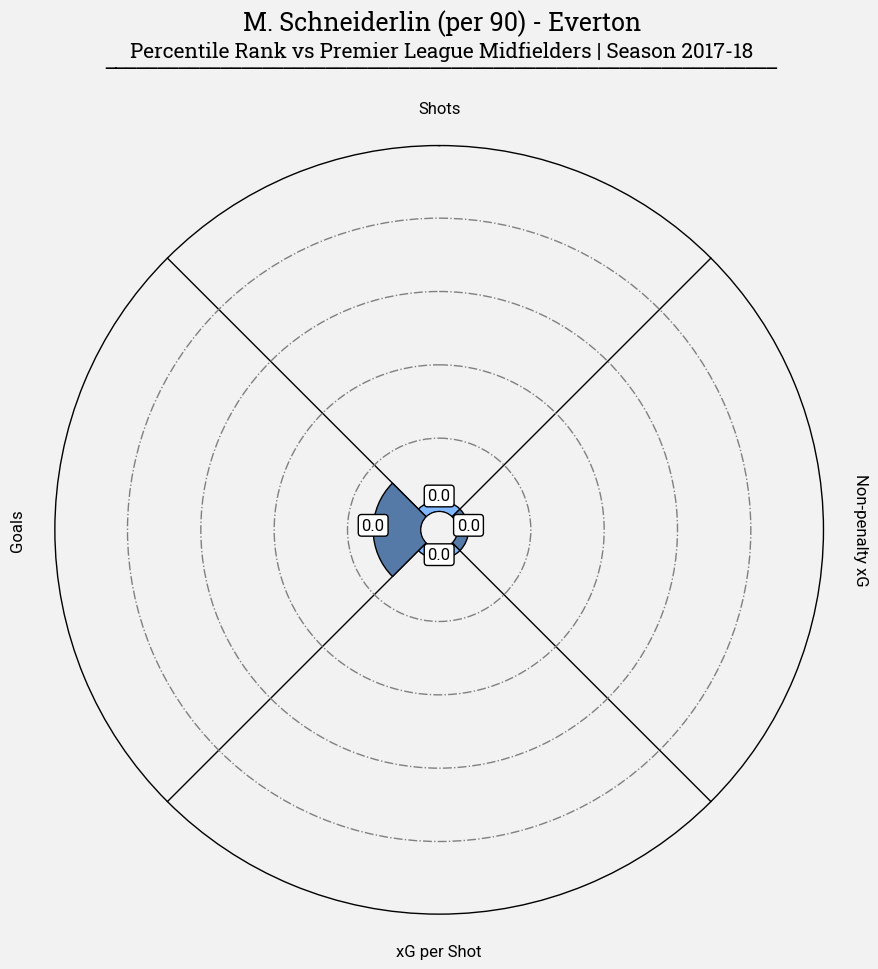

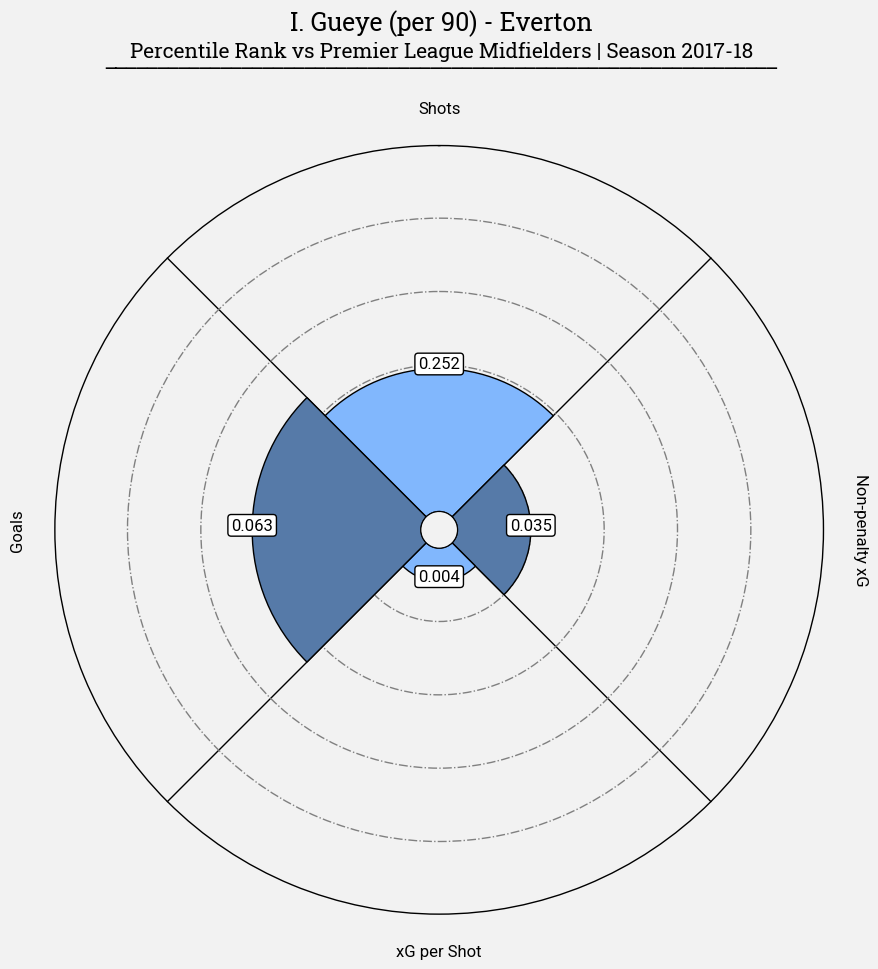

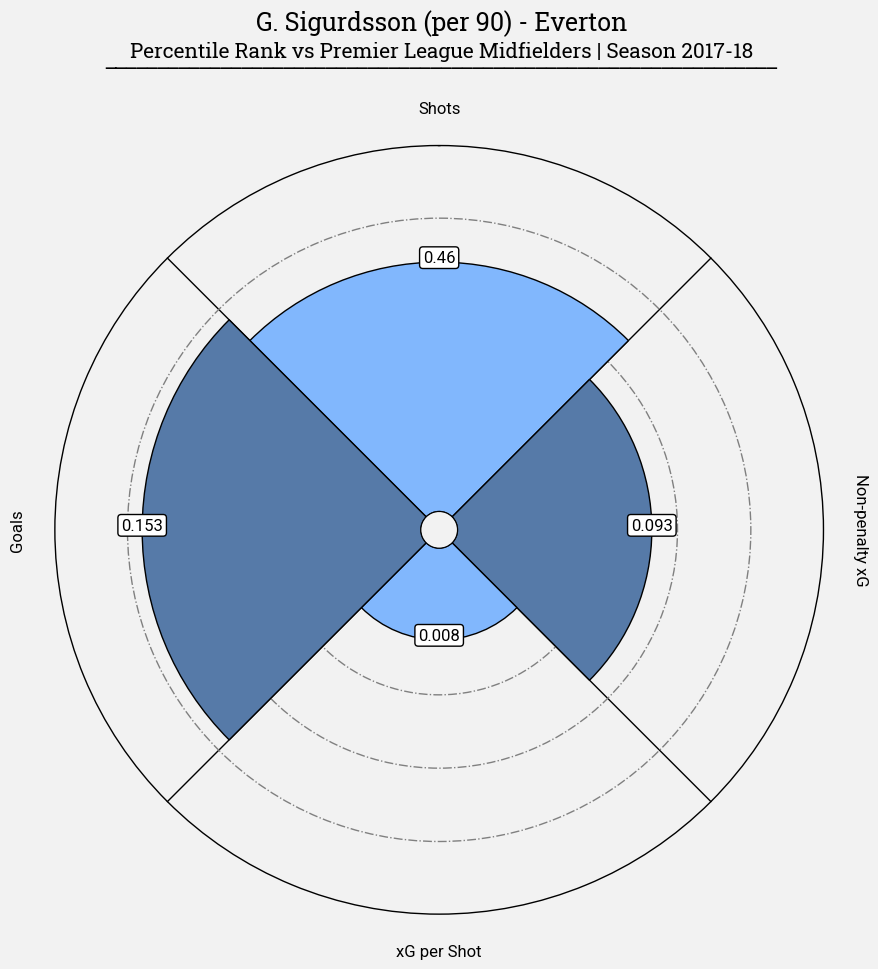

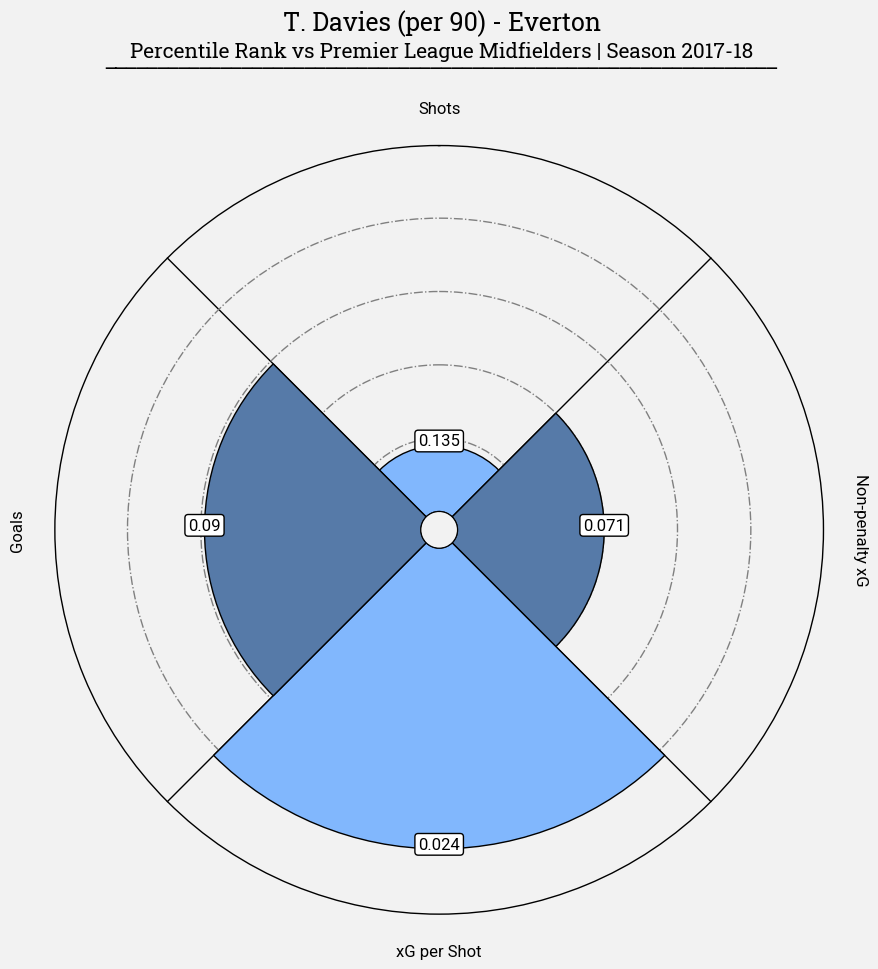

In [154]:
for player in everton_df.shortName.unique().tolist():

    player_perc = everton_df.loc[everton_df['shortName']==player,['Shots','Non-penalty xG','xG per Shot','Goals']]
    player_raw = everton_df_raw.loc[everton_df_raw['shortName']==player,['Shots','Non-penalty xG','xG per Shot','Goals']]

    team = everton_df_raw.loc[everton_df_raw['shortName']==player,'teamName'].values[0]

    names = ['Shots','Non-penalty xG','xG per Shot','Goals']
    values = [player_raw[column].iloc[0] for column in names]
    percentiles = [np.round((player_perc[column].iloc[0])*100,0) for column in names]
    #list of names on plots
    slice_colors = ["#81b7fd","#567aa8","#81b7fd","#567aa8"]
    text_colors = ["black"] * len(names)
    font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                            "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
    font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                            "RobotoSlab%5Bwght%5D.ttf?raw=true"))
    #PIZZA PLOT
    baker = PyPizza(
        params=names,
        min_range = None,
        max_range = None,               # list of parameters
        straight_line_color="#000000",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=2,               # linewidth of last circle
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-."            # linestyle for other circles
    )
    #making pizza for our data
    fig, ax = baker.make_pizza(
        percentiles,              # list of values
        figsize=(10, 10),      # adjust figsize according to your need
        param_location=110,
        slice_colors = slice_colors,
        value_colors = text_colors,
        value_bck_colors = ["white"]*len(names), # where the parameters will be added
        kwargs_slices=dict(
            #facecolor="cornflowerblue", 
            edgecolor="#000000",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, va="center"
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", #facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    #putting text
    texts = baker.get_value_texts()
    for i, text in enumerate(texts):
        text.set_text(str(np.round(values[i],3)))

    # add title
    fig.text(
        x=0.515,
        y= 0.995,
        s=f"{player} (per 90) - {team}",
        size=18,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop,
    )

    # add subtitle
    fig.text(
        x=0.515,
        y=0.968,
        s="Percentile Rank vs Premier League Midfielders | Season 2017-18",
        size=15,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop
    )
    
    fig.text(
        x=0.515,
        y=0.962,
        s="________________________________________________________________",
        size=15,
        ha="center",
        color="#000000",
    )
    
    plt.show()

In [121]:
rank_per_90.loc[34,'lastName'] = "Gross"
rank_per_90.loc[34,'shortName'] = "P. Gross"
summary_per_90.loc[34,'lastName'] = "Gross"
summary_per_90.loc[34,'shortName'] = "P. Gross"

possible_candidates = ['A. Mooy','L. Narsingh',"P. Gross",'A. Iwobi','D. Gray','J. Wilshere','M. Lanzini','R. Pereyra','N. Redmond','R. Fraser']
candidates_perc = rank_per_90.loc[rank_per_90['shortName'].isin(possible_candidates)]
candidates_raw = summary_per_90.loc[summary_per_90['shortName'].isin(possible_candidates)]

candidates_perc = candidates_perc.rename(columns=column_names)
candidates_raw = candidates_raw.rename(columns=column_names)

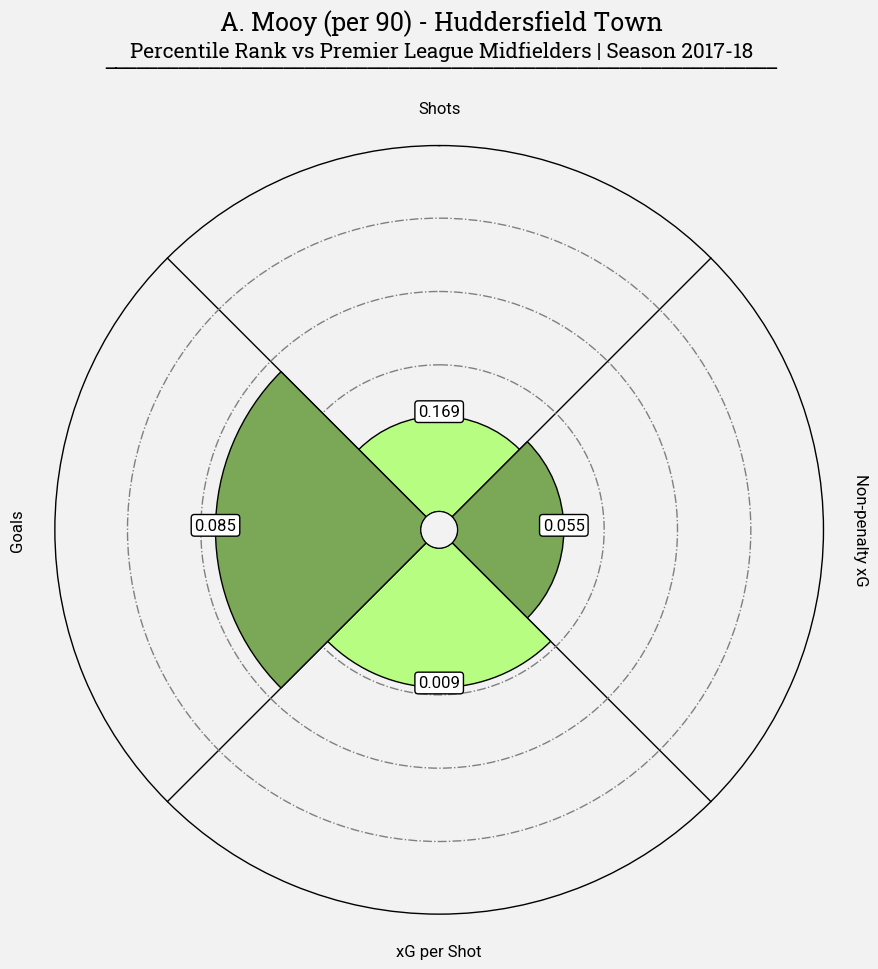

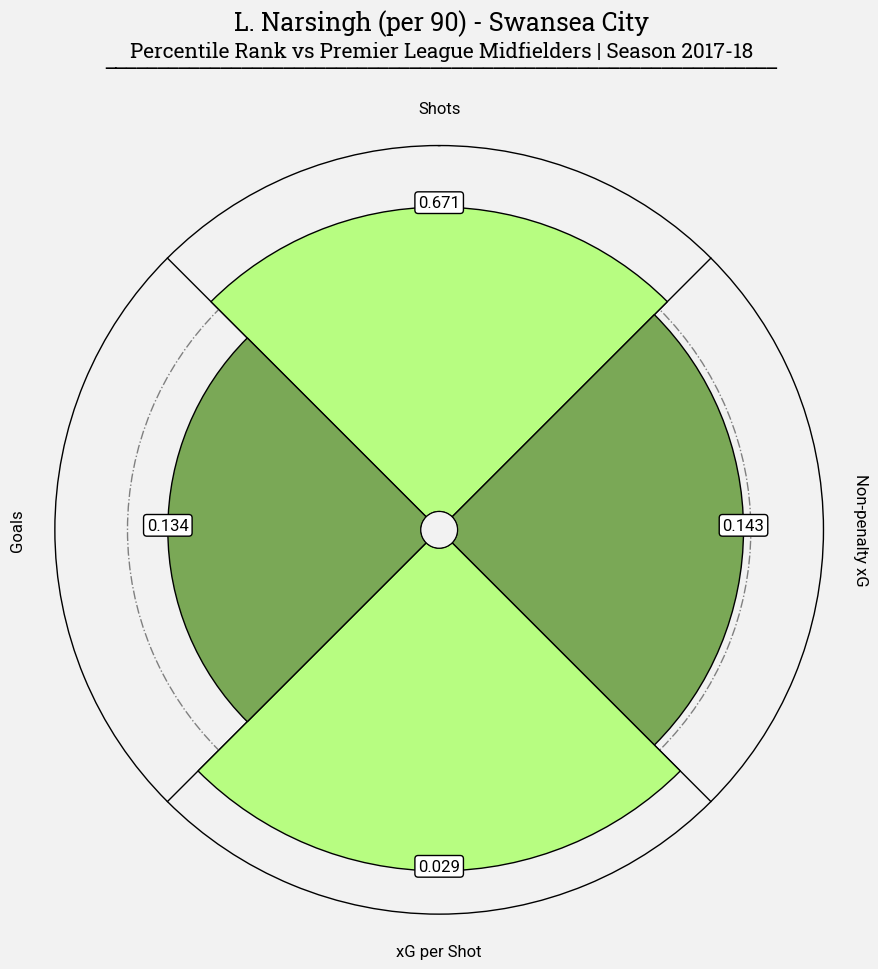

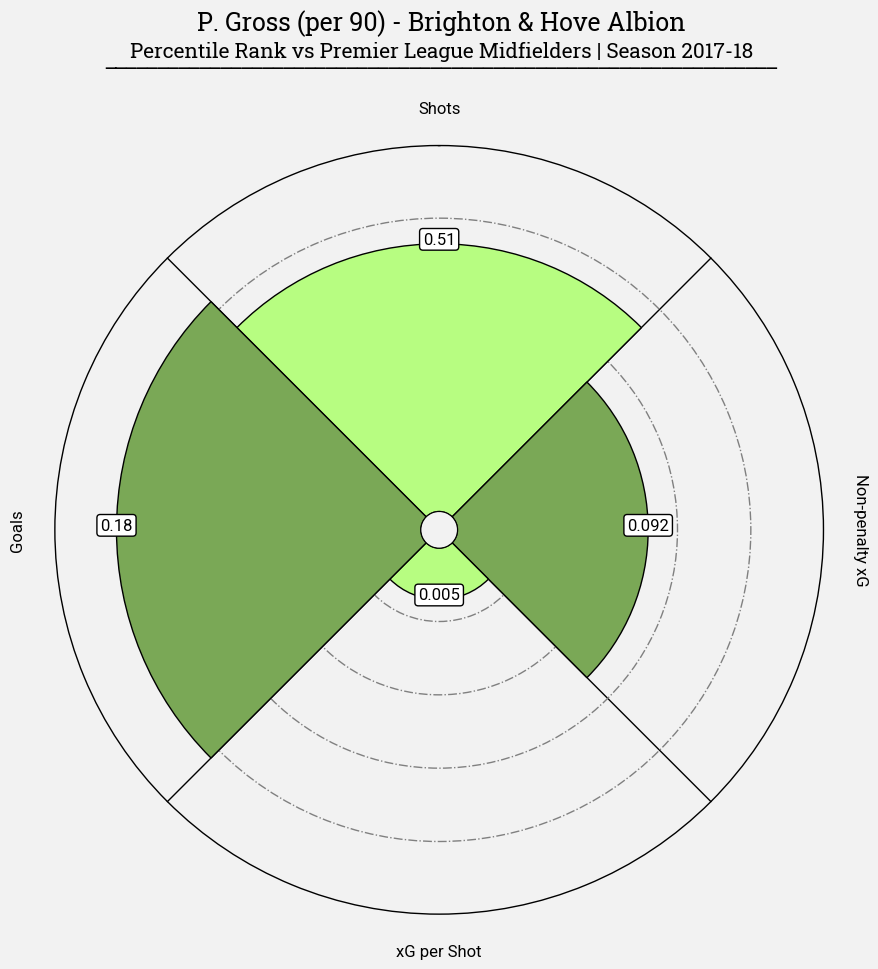

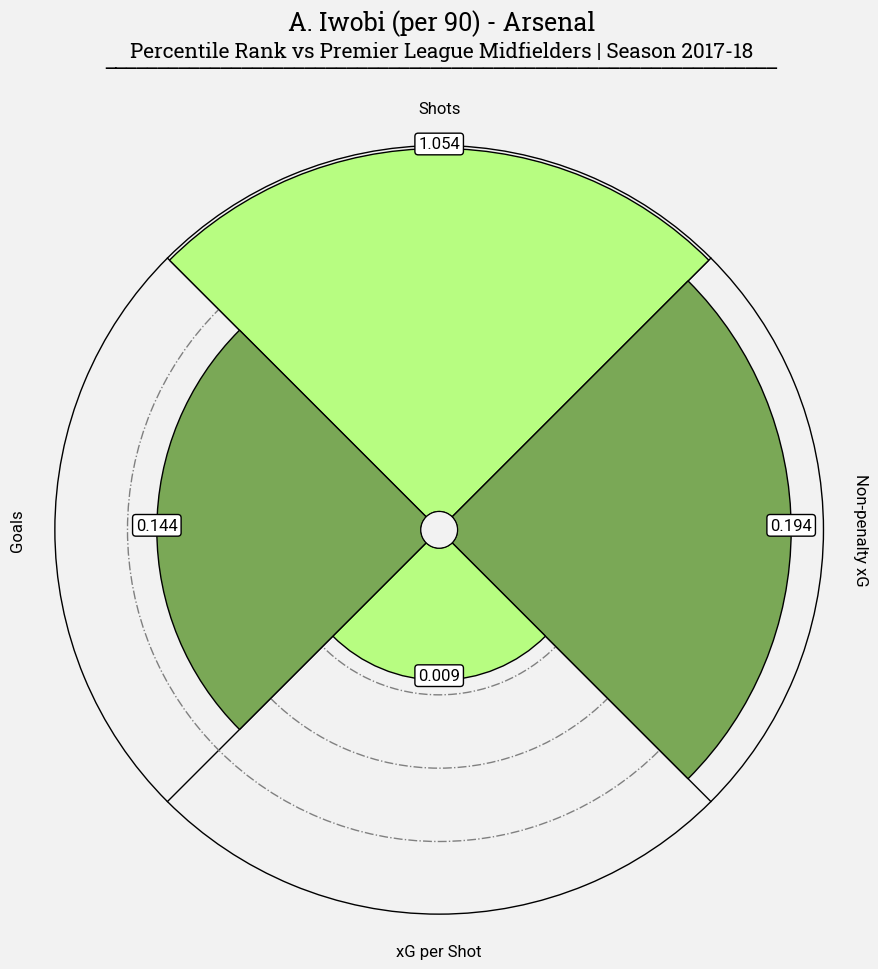

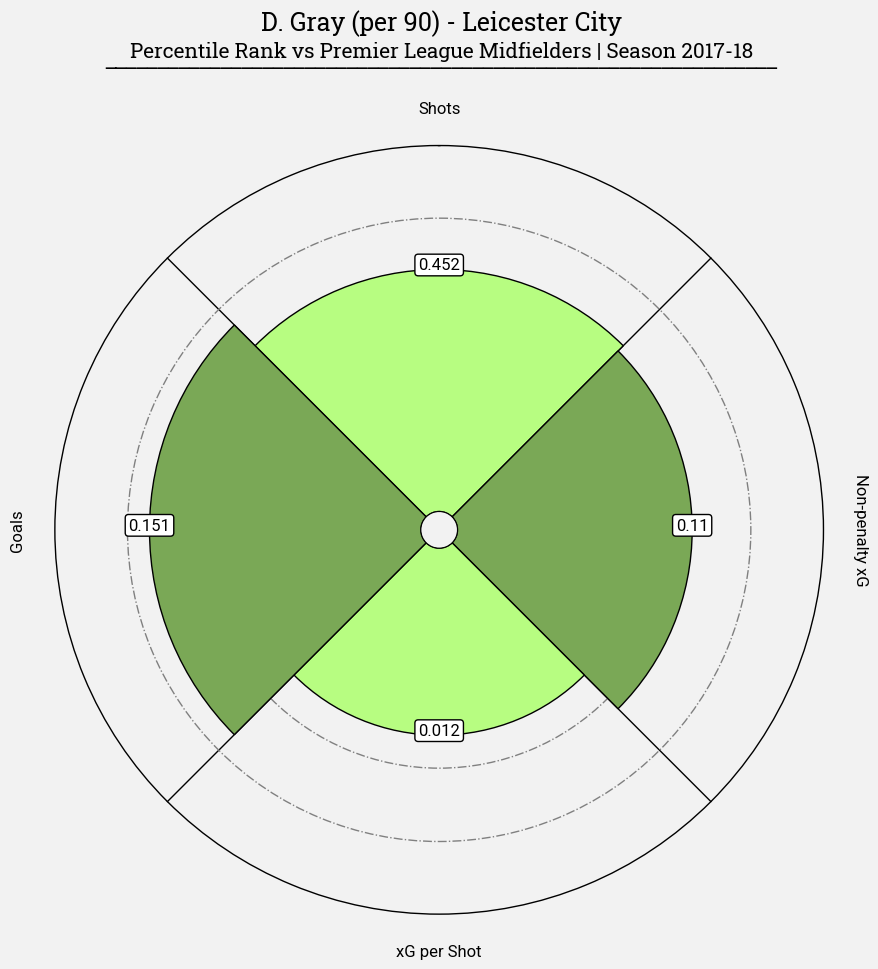

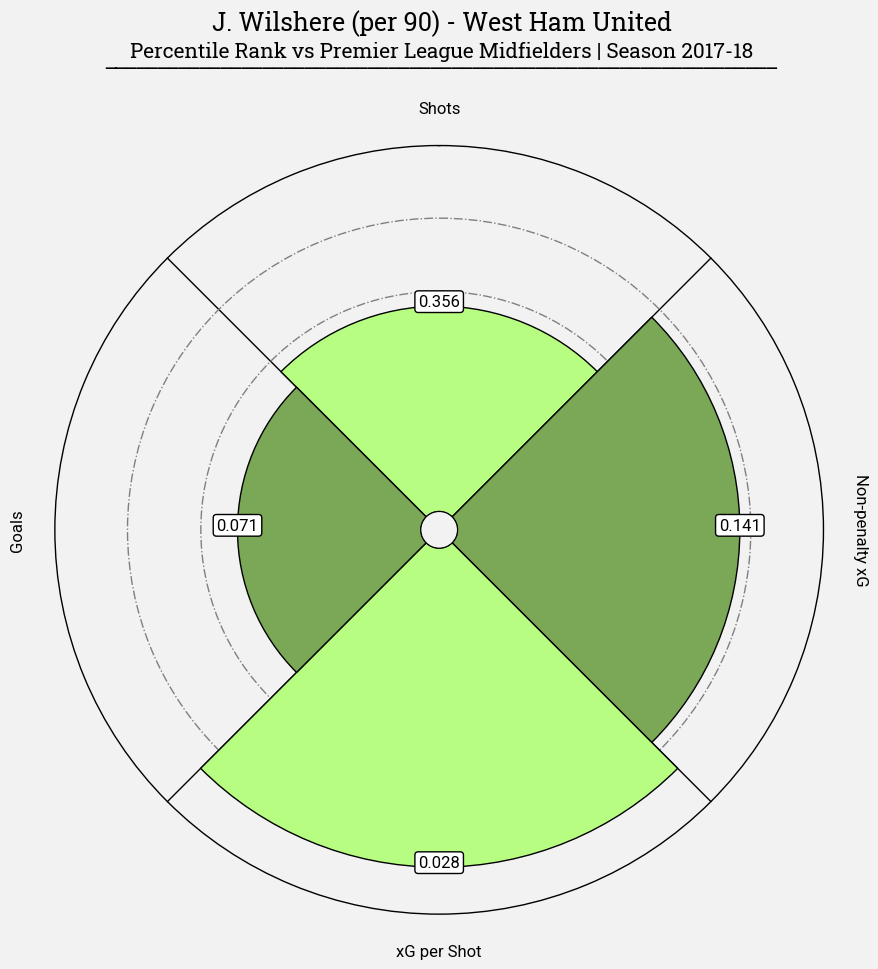

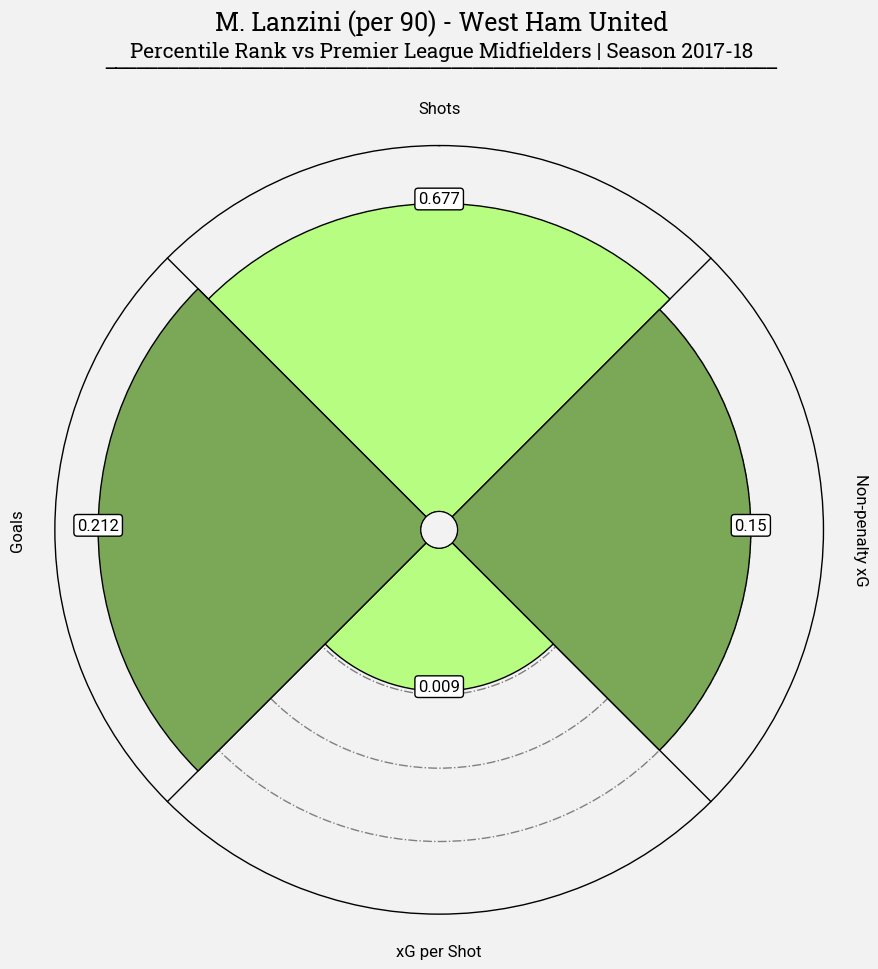

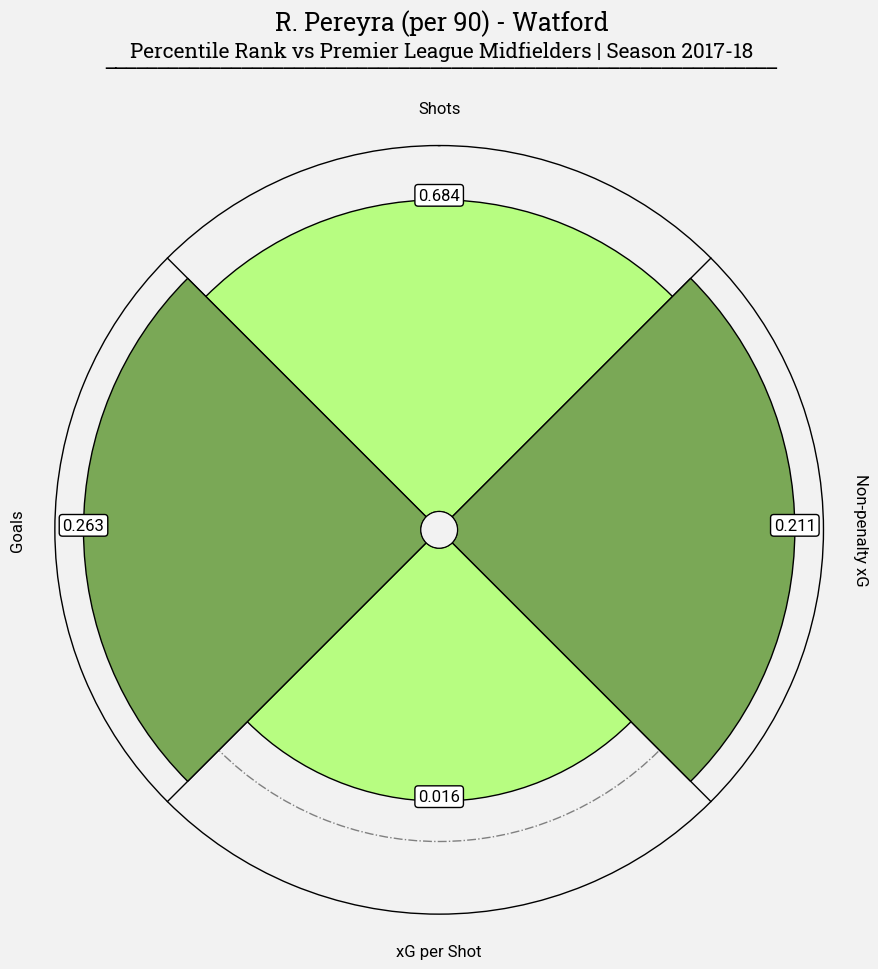

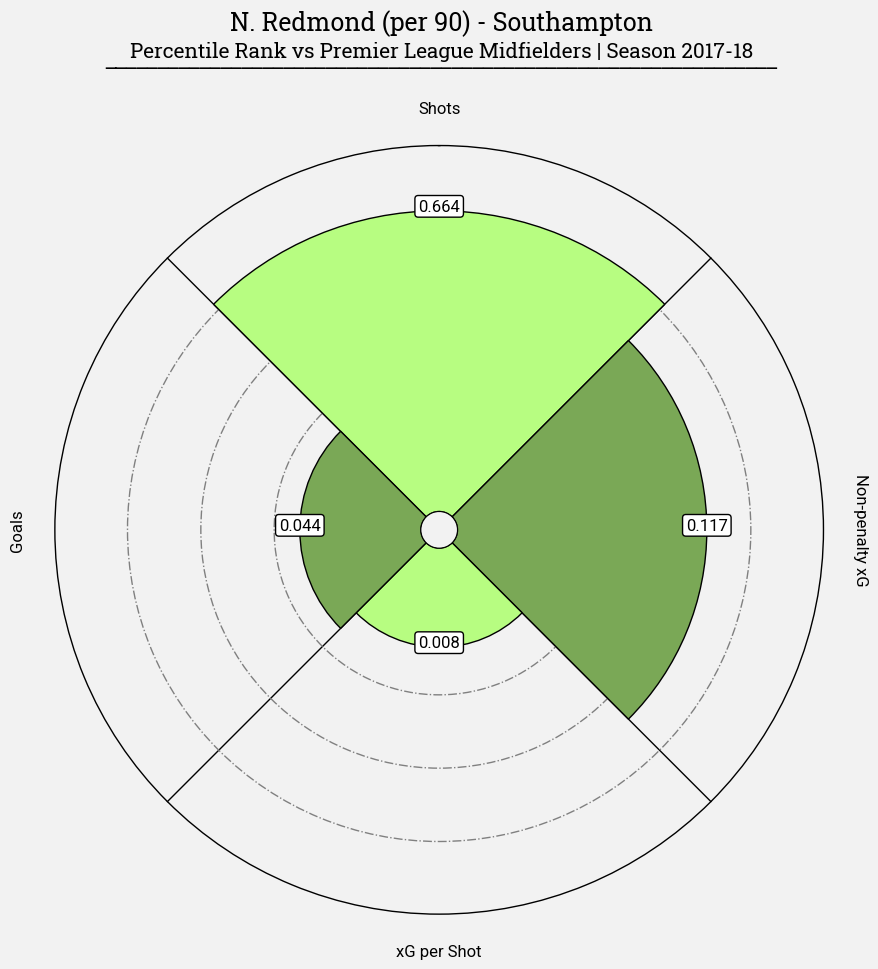

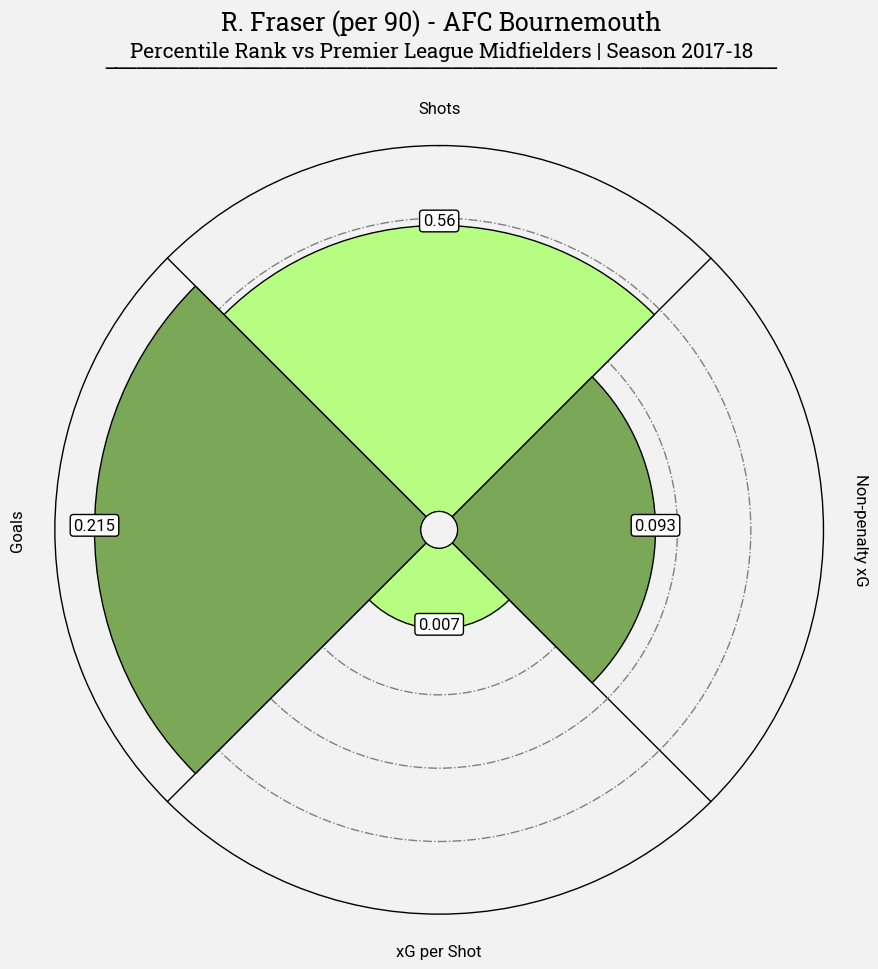

In [148]:
for player in candidates_perc['shortName'].unique().tolist():
    player_perc = candidates_perc.loc[candidates_perc['shortName']==player,['Shots','Non-penalty xG','xG per Shot','Goals']]
    player_raw = candidates_raw.loc[candidates_raw['shortName']==player,['Shots','Non-penalty xG','xG per Shot','Goals']]
    team = candidates_raw.loc[candidates_raw['shortName']==player,'teamName'].values[0]
    names = ['Shots','Non-penalty xG','xG per Shot','Goals']
    values = [player_raw[column].iloc[0] for column in names]
    percentiles = [np.round((player_perc[column].iloc[0])*100,0) for column in names]
    
    #list of names on plots
    slice_colors = ["#b7fd81","#7aa856","#b7fd81","#7aa856"]
    text_colors = ["black"] * len(names)
    font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                            "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
    font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                            "RobotoSlab%5Bwght%5D.ttf?raw=true"))
    #PIZZA PLOT
    baker = PyPizza(
        params=names,
        min_range = None,
        max_range = None,               # list of parameters
        straight_line_color="#000000",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=2,               # linewidth of last circle
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-."            # linestyle for other circles
    )
    #making pizza for our data
    fig, ax = baker.make_pizza(
        percentiles,              # list of values
        figsize=(10, 10),      # adjust figsize according to your need
        param_location=110,
        slice_colors = slice_colors,
        value_colors = text_colors,
        value_bck_colors = ["white"]*len(names), # where the parameters will be added
        kwargs_slices=dict(
            #facecolor="cornflowerblue", 
            edgecolor="#000000",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, va="center"
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", #facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    #putting text
    texts = baker.get_value_texts()
    for i, text in enumerate(texts):
        text.set_text(str(np.round(values[i],3)))

    # add title
    fig.text(
        x=0.515,
        y= 0.995,
        s=f"{player} (per 90) - {team}",
        size=18,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop,
    )

    # add subtitle
    fig.text(
        x=0.515,
        y=0.968,
        s="Percentile Rank vs Premier League Midfielders | Season 2017-18",
        size=15,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop
    )

    fig.text(
        x=0.515,
        y=0.962,
        s="________________________________________________________________",
        size=15,
        ha="center",
        color="#000000",
    )
    
    plt.show()

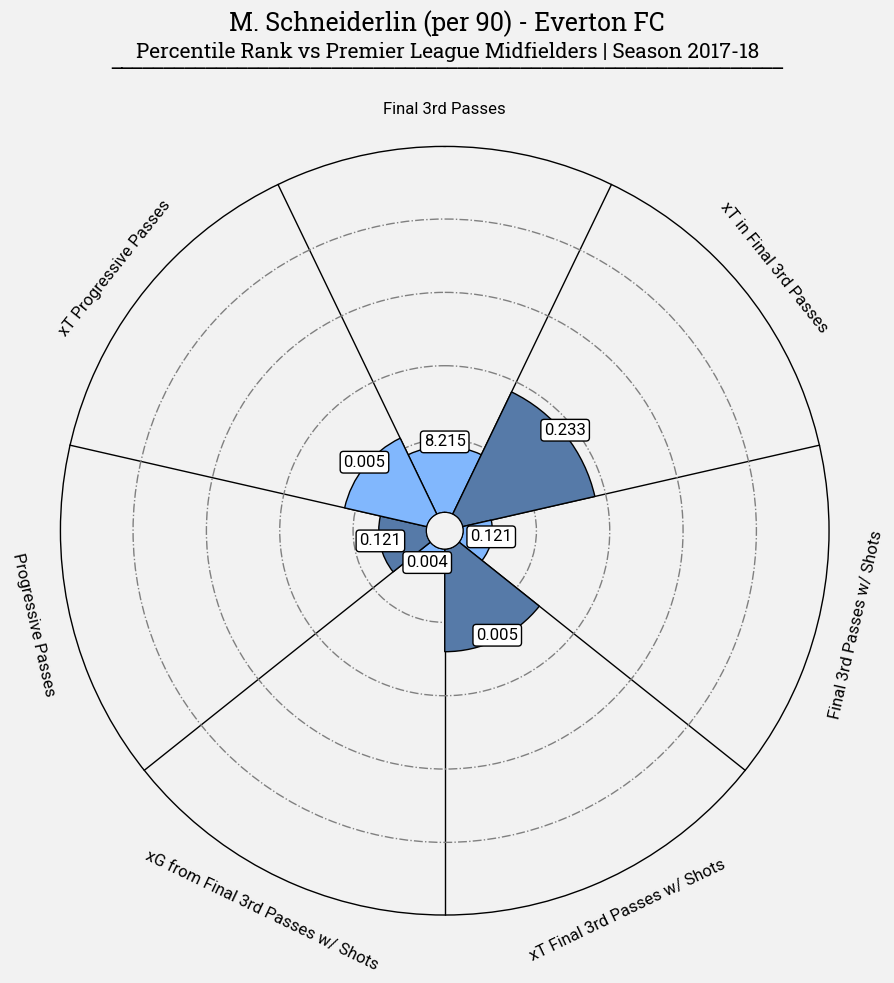

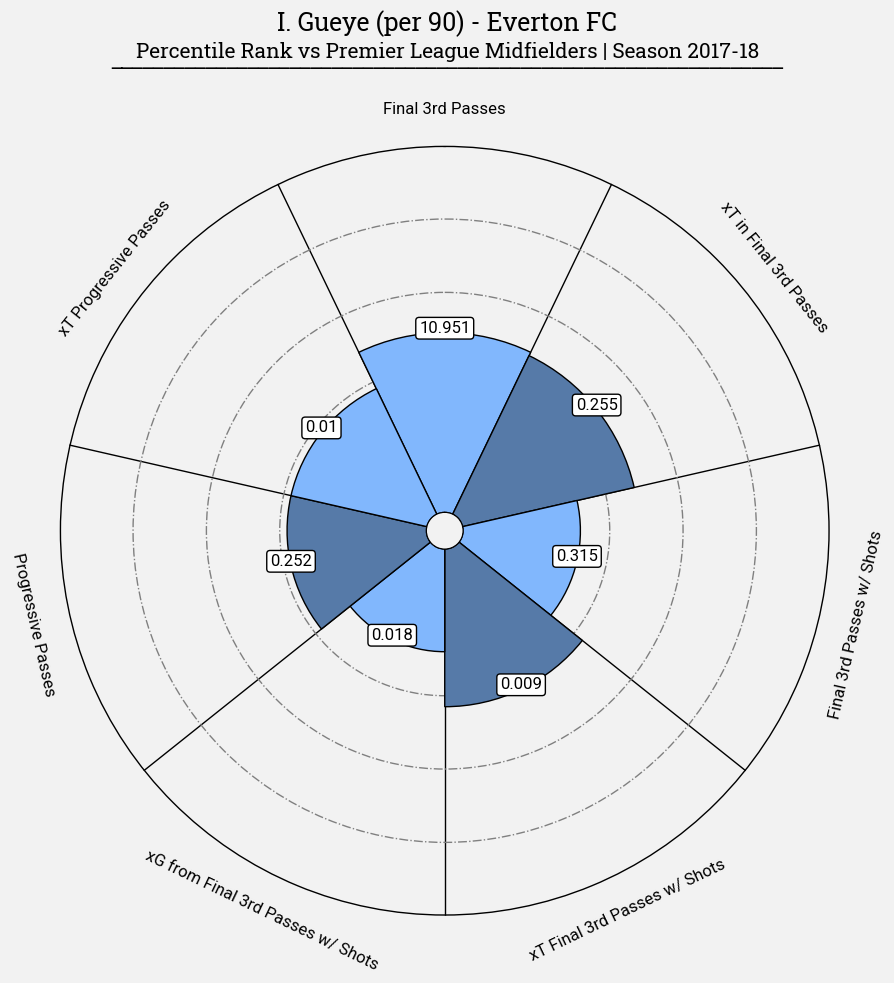

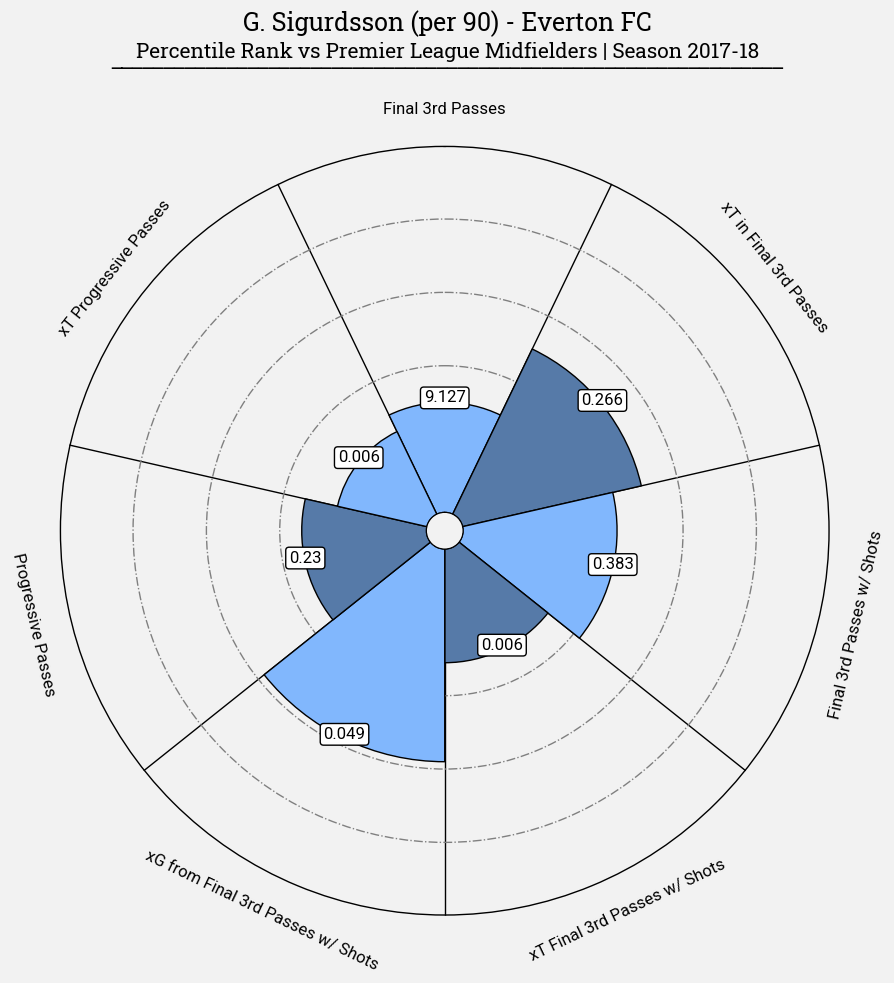

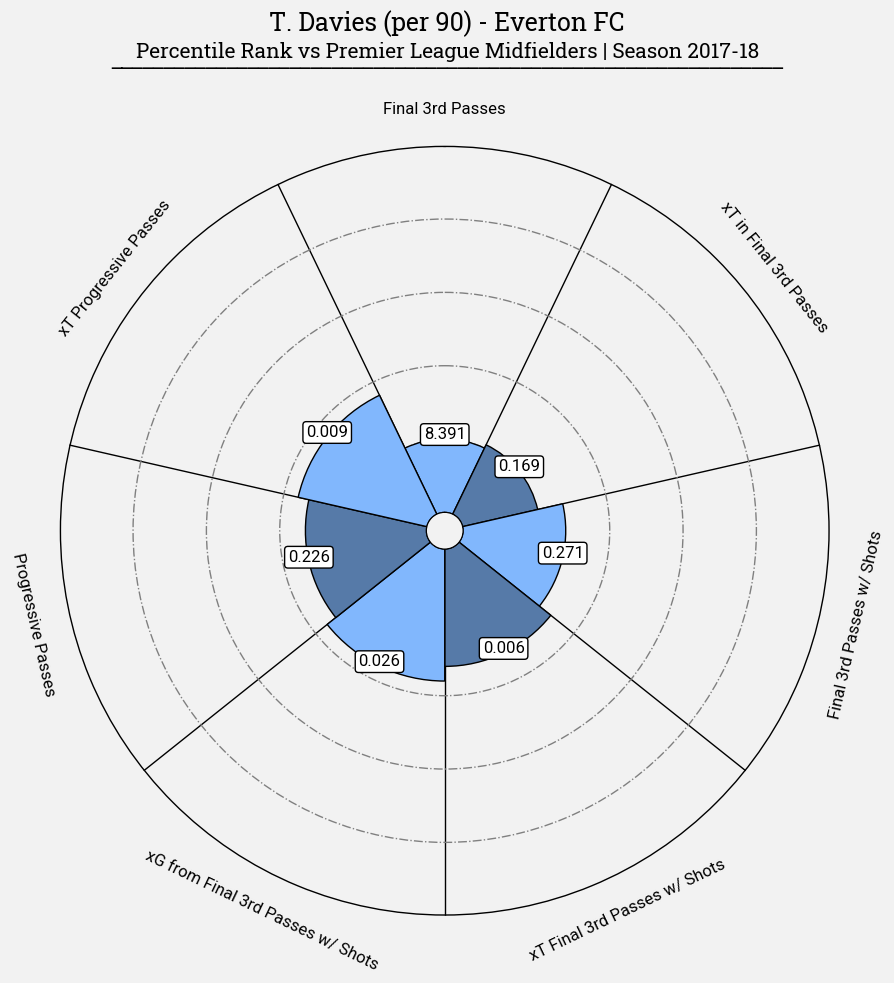

In [149]:
for player in everton_df.shortName.unique().tolist():
    names = ['Final 3rd Passes','xT in Final 3rd Passes','Final 3rd Passes w/ Shots','xT Final 3rd Passes w/ Shots',
             'xG from Final 3rd Passes w/ Shots','Progressive Passes','xT Progressive Passes']
    player_perc = everton_df.loc[everton_df['shortName']==player,names]
    player_raw = everton_df_raw.loc[everton_df_raw['shortName']==player,names]

    values = [player_raw[column].iloc[0] for column in names]
    percentiles = [np.round((player_perc[column].iloc[0])*100,0) for column in names]
    #list of names on plots
    slice_colors = ["#81b7fd","#567aa8","#81b7fd","#567aa8","#81b7fd","#567aa8","#81b7fd"]
    text_colors = ["black"] * len(names)
    font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                            "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
    font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                            "RobotoSlab%5Bwght%5D.ttf?raw=true"))
    #PIZZA PLOT
    baker = PyPizza(
        params=names,
        min_range = None,
        max_range = None,               # list of parameters
        straight_line_color="#000000",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=2,               # linewidth of last circle
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-."            # linestyle for other circles
    )
    #making pizza for our data
    fig, ax = baker.make_pizza(
        percentiles,              # list of values
        figsize=(10, 10),      # adjust figsize according to your need
        param_location=110,
        slice_colors = slice_colors,
        value_colors = text_colors,
        value_bck_colors = ["white"]*len(names), # where the parameters will be added
        kwargs_slices=dict(
            #facecolor="cornflowerblue", 
            edgecolor="#000000",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, va="center"
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", #facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    #putting text
    texts = baker.get_value_texts()
    for i, text in enumerate(texts):
        text.set_text(str(np.round(values[i],3)))

    # add title
    fig.text(
        x=0.515,
        y= 0.995,
        s=f"{player} (per 90) - Everton FC",
        size=18,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop,
    )

    # add subtitle
    fig.text(
        x=0.515,
        y=0.968,
        s="Percentile Rank vs Premier League Midfielders | Season 2017-18",
        size=15,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop
    )

    fig.text(
        x=0.515,
        y=0.962,
        s="________________________________________________________________",
        size=15,
        ha="center",
        color="#000000",
    )
    
    plt.show()

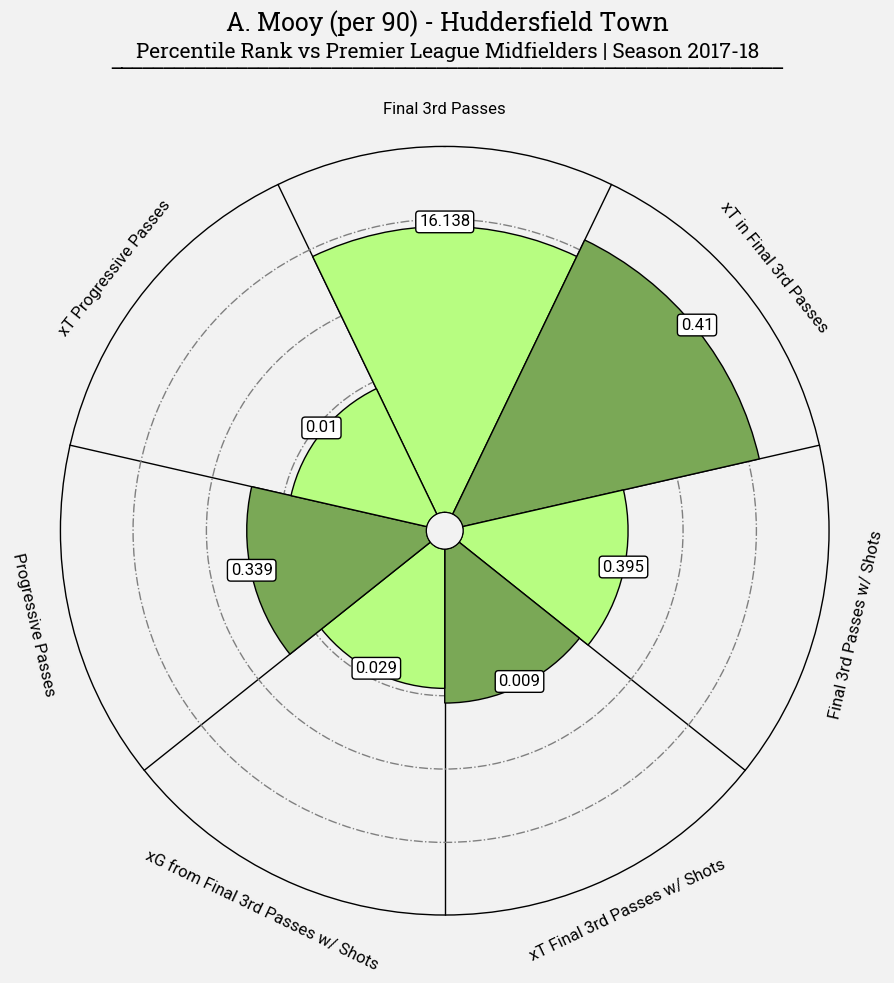

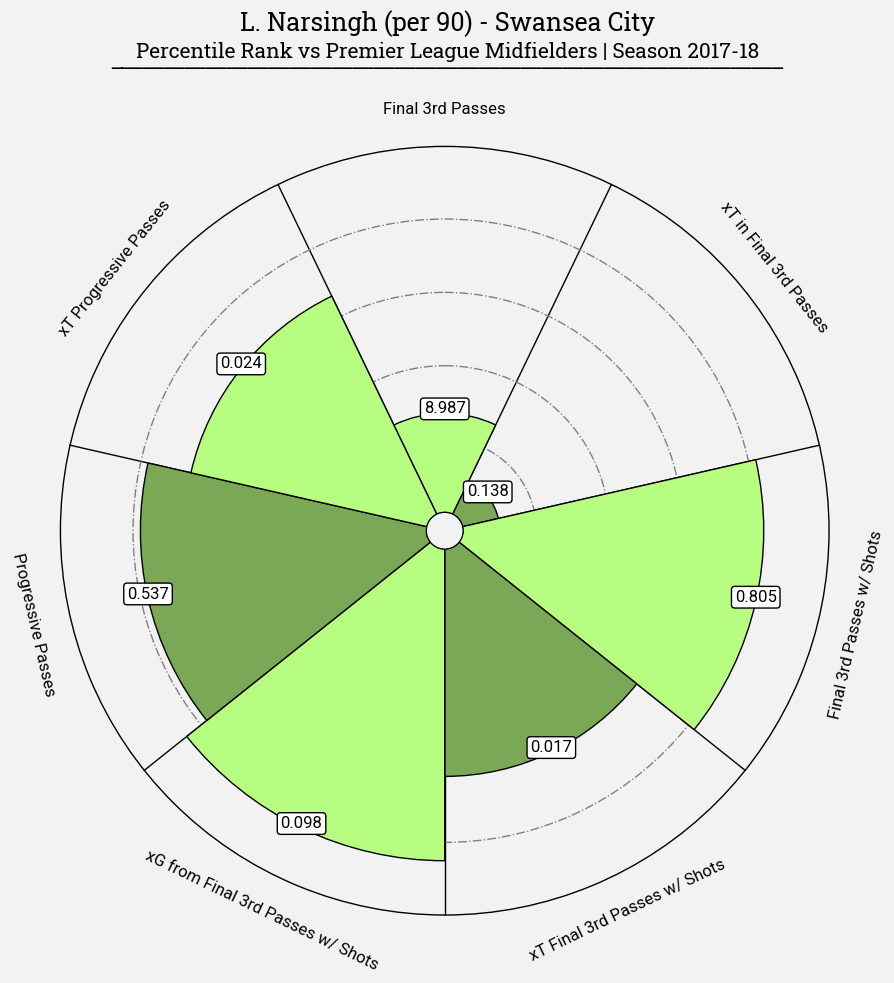

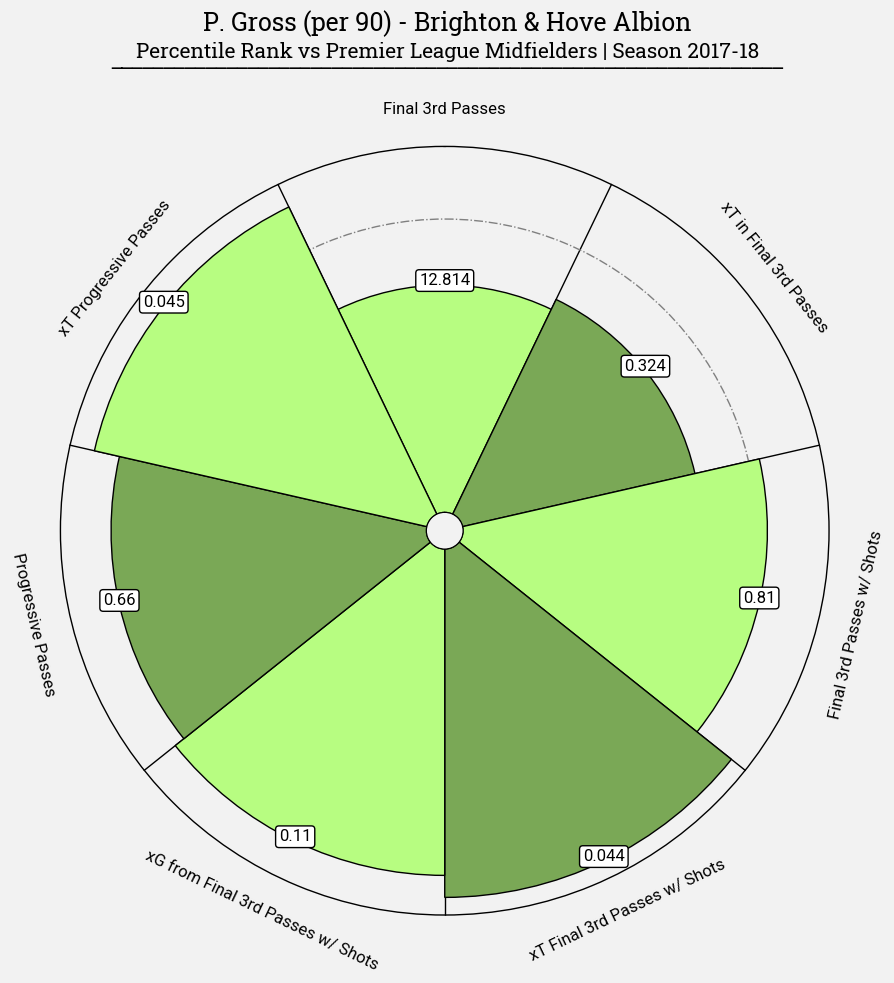

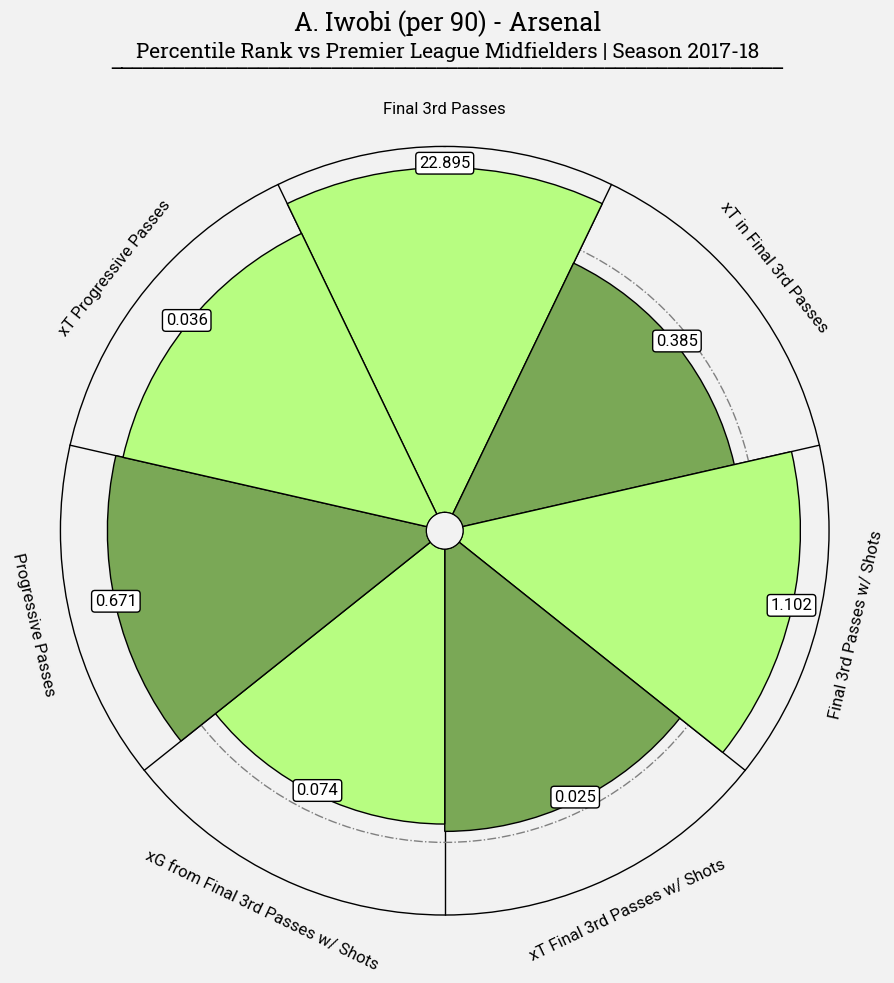

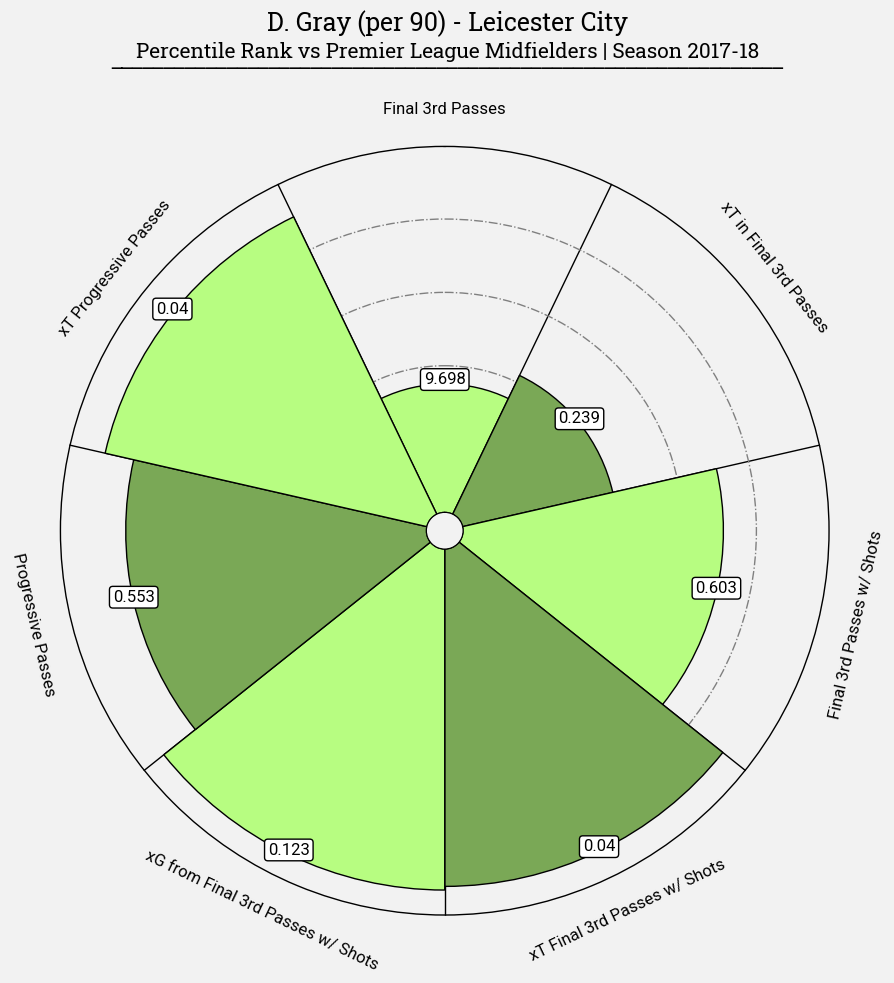

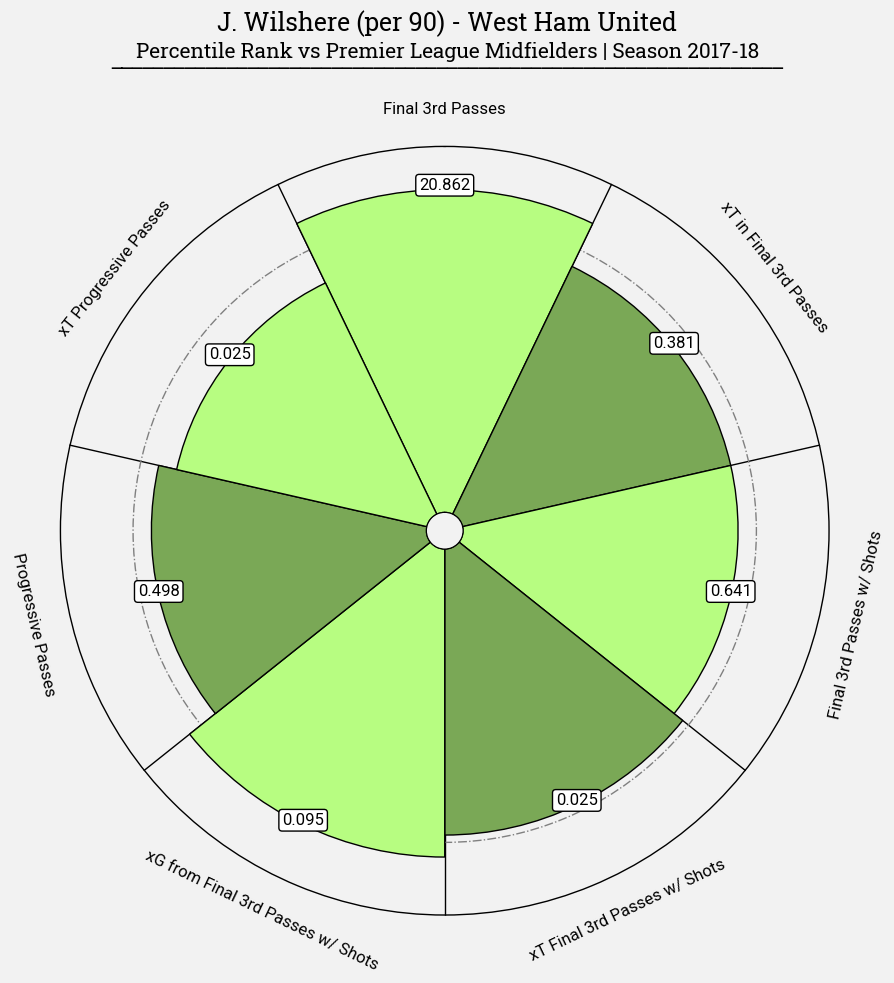

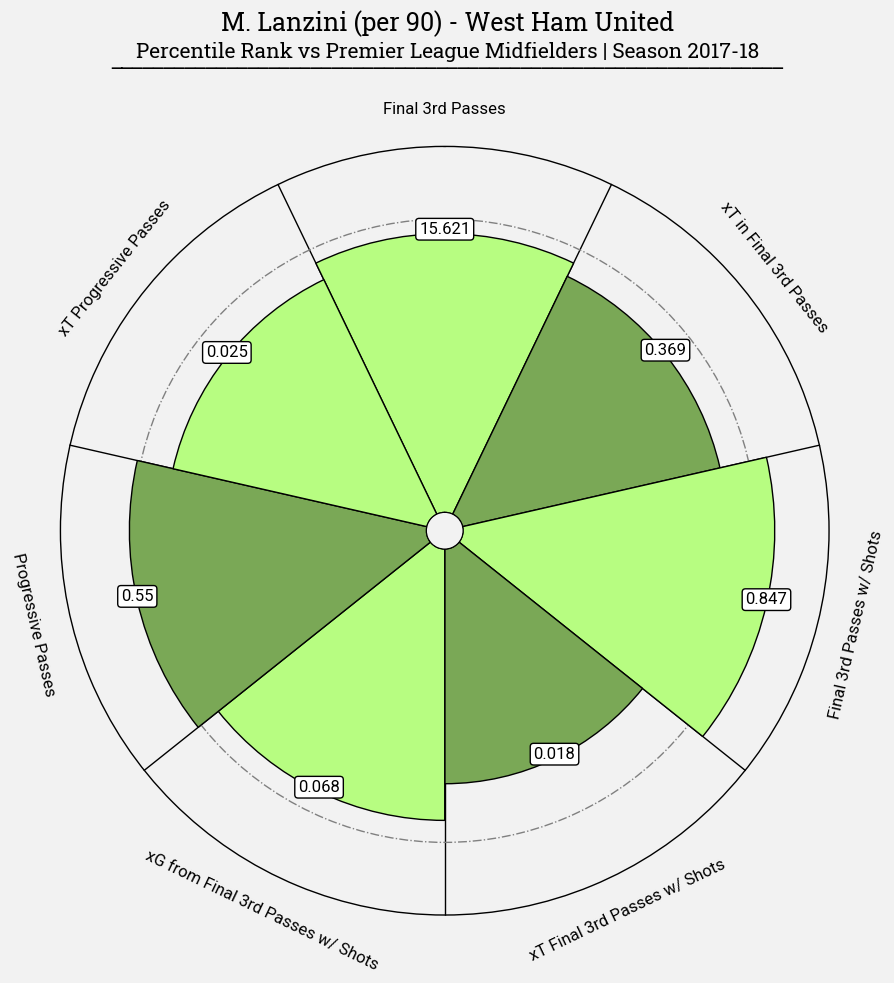

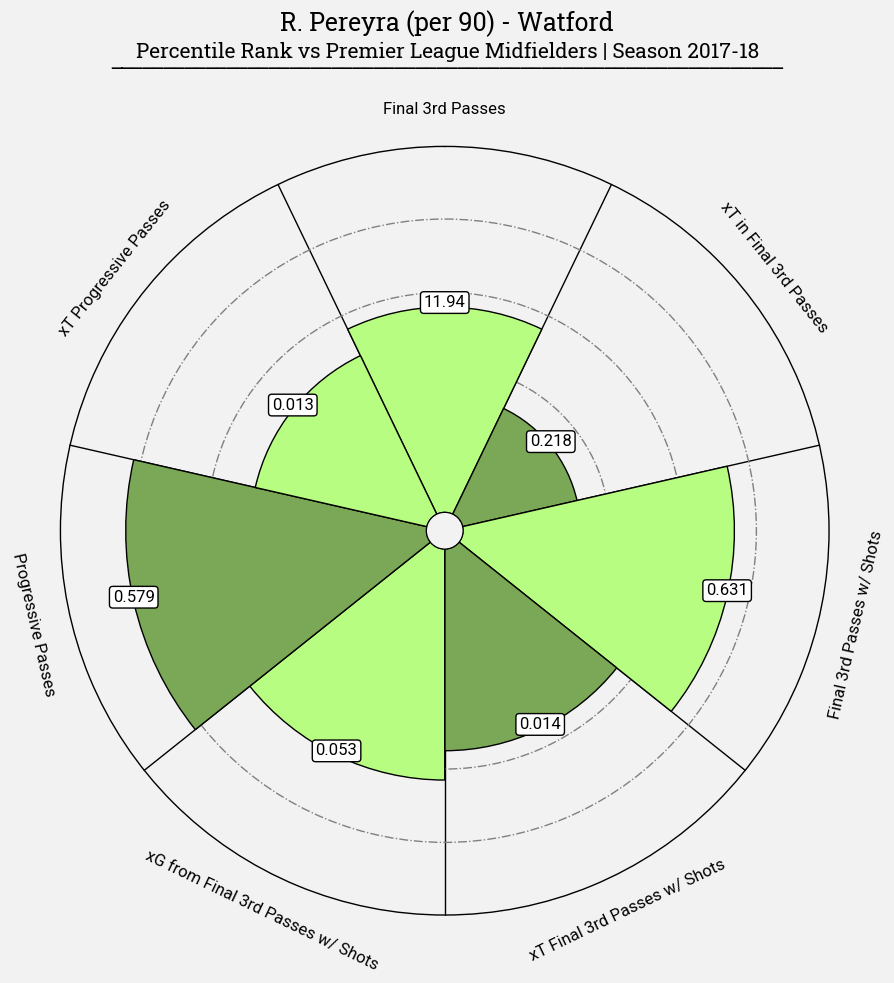

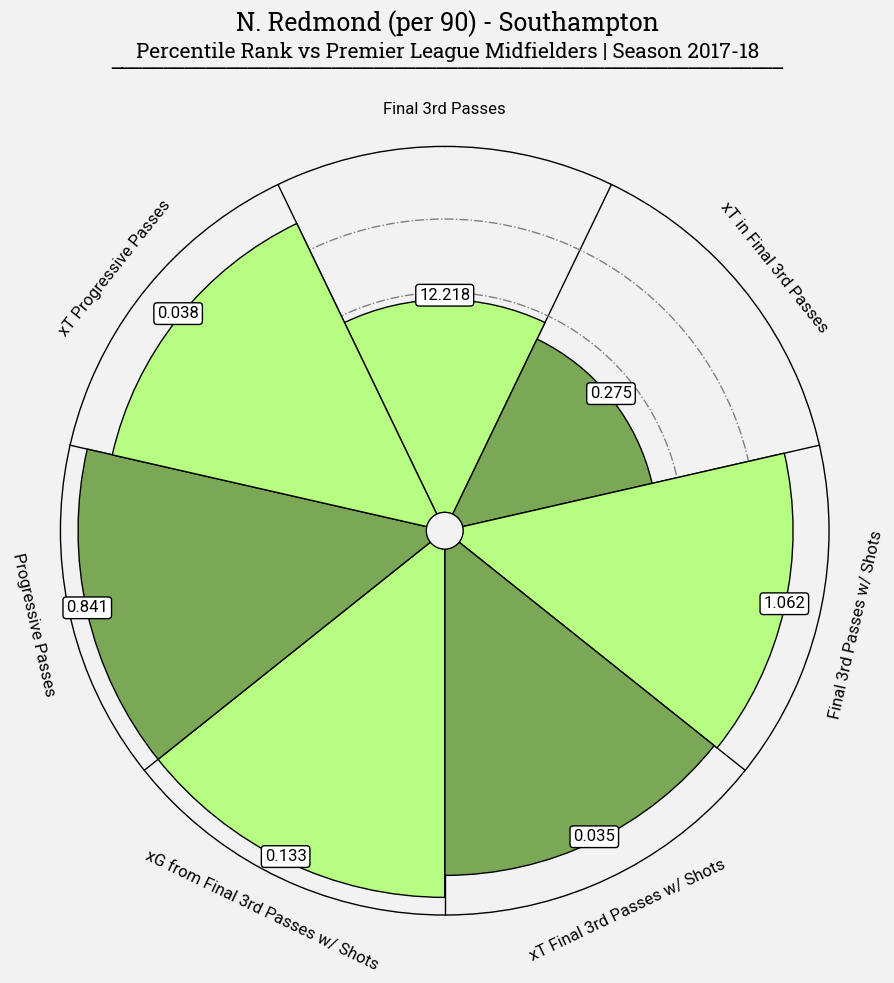

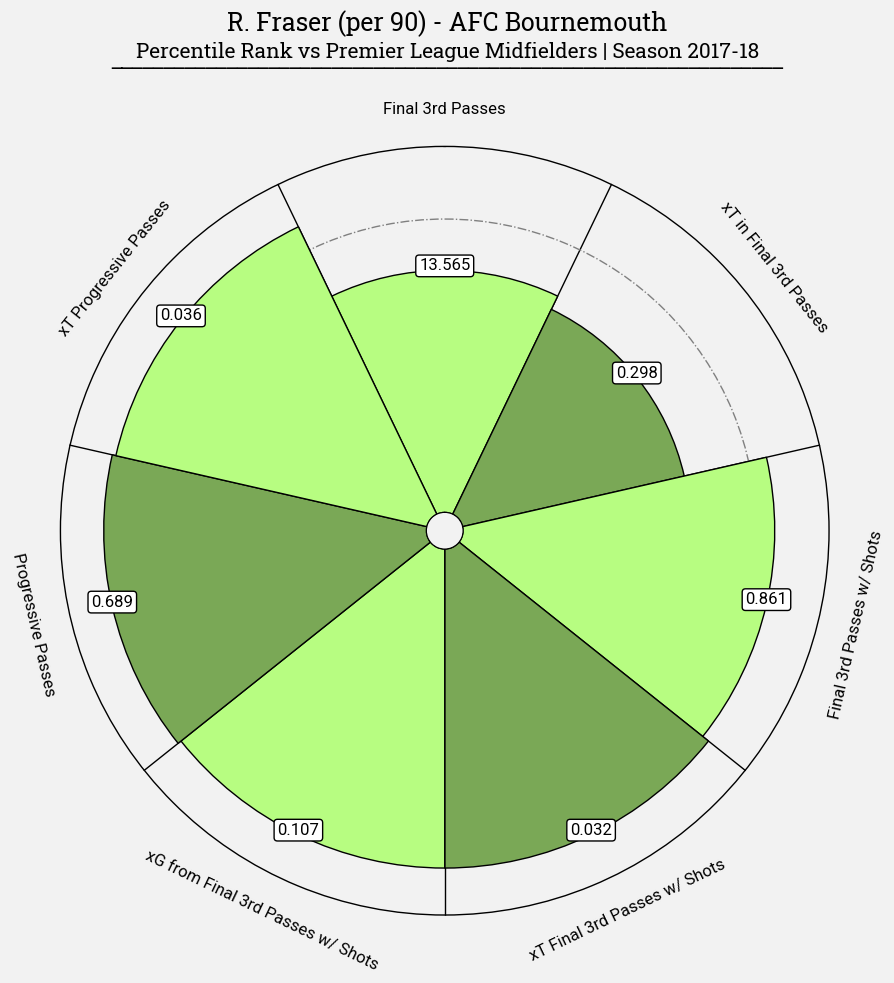

In [150]:
for player in candidates_perc['shortName'].unique().tolist():
    names = ['Final 3rd Passes','xT in Final 3rd Passes','Final 3rd Passes w/ Shots','xT Final 3rd Passes w/ Shots',
             'xG from Final 3rd Passes w/ Shots','Progressive Passes','xT Progressive Passes']
    player_perc = candidates_perc.loc[candidates_perc['shortName']==player,names]
    player_raw = candidates_raw.loc[candidates_raw['shortName']==player,names]
    
    team = candidates_raw.loc[candidates_raw['shortName']==player,'teamName'].values[0]

    values = [player_raw[column].iloc[0] for column in names]
    percentiles = [np.round((player_perc[column].iloc[0])*100,0) for column in names]
    
    #list of names on plots
    slice_colors = ["#b7fd81","#7aa856","#b7fd81","#7aa856","#b7fd81","#7aa856","#b7fd81"]
    text_colors = ["black"] * len(names)
    font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                            "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
    font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                            "RobotoSlab%5Bwght%5D.ttf?raw=true"))
    #PIZZA PLOT
    baker = PyPizza(
        params=names,
        min_range = None,
        max_range = None,               # list of parameters
        straight_line_color="#000000",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=2,               # linewidth of last circle
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-."            # linestyle for other circles
    )
    #making pizza for our data
    fig, ax = baker.make_pizza(
        percentiles,              # list of values
        figsize=(10, 10),      # adjust figsize according to your need
        param_location=110,
        slice_colors = slice_colors,
        value_colors = text_colors,
        value_bck_colors = ["white"]*len(names), # where the parameters will be added
        kwargs_slices=dict(
            #facecolor="cornflowerblue", 
            edgecolor="#000000",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, va="center"
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", #facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    #putting text
    texts = baker.get_value_texts()
    for i, text in enumerate(texts):
        text.set_text(str(np.round(values[i],3)))

    # add title
    fig.text(
        x=0.515,
        y= 0.995,
        s=f"{player} (per 90) - {team}",
        size=18,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop,
    )

    # add subtitle
    fig.text(
        x=0.515,
        y=0.968,
        s="Percentile Rank vs Premier League Midfielders | Season 2017-18",
        size=15,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop
    )

    fig.text(
        x=0.515,
        y=0.962,
        s="________________________________________________________________",
        size=15,
        ha="center",
        color="#000000",
    )
    
    plt.show()